# 1. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

import collections
import time
import warnings
warnings.filterwarnings('ignore')


In [2]:
train = pd.read_csv('./cell2celltrain.csv')
test = pd.read_csv('./cell2cellholdout.csv')
train.head(1)

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.0,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No


In [3]:
train.isnull().sum().sort_values(ascending=False)

AgeHH2                       909
AgeHH1                       909
PercChangeMinutes            367
PercChangeRevenues           367
MonthlyRevenue               156
MonthlyMinutes               156
TotalRecurringCharge         156
DirectorAssistedCalls        156
OverageMinutes               156
RoamingCalls                 156
ServiceArea                   24
CurrentEquipmentDays           1
Handsets                       1
HandsetModels                  1
OwnsComputer                   0
NonUSTravel                    0
BuysViaMailOrder               0
OptOutMailings                 0
RespondsToMailOffers           0
RetentionCalls                 0
HasCreditCard                  0
IncomeGroup                    0
RetentionOffersAccepted        0
NewCellphoneUser               0
NotNewCellphoneUser            0
ReferralsMadeBySubscriber      0
RVOwner                        0
OwnsMotorcycle                 0
AdjustmentsToCreditRating      0
HandsetPrice                   0
MadeCallTo

# 2. train data Preprocessing
~~~
- 공통 진행 : Age는 두 가지 컬럼이 있어서 하나의 평균값으로 대체
~~~

In [4]:
train['Age'] = (train['AgeHH1'] + train['AgeHH2'])/2
test['Age'] = (test['AgeHH1'] + test['AgeHH2'])/2
train.drop(['AgeHH1', 'AgeHH2'], axis=1, inplace=True)
test.drop(['AgeHH1', 'AgeHH2'], axis=1, inplace=True)

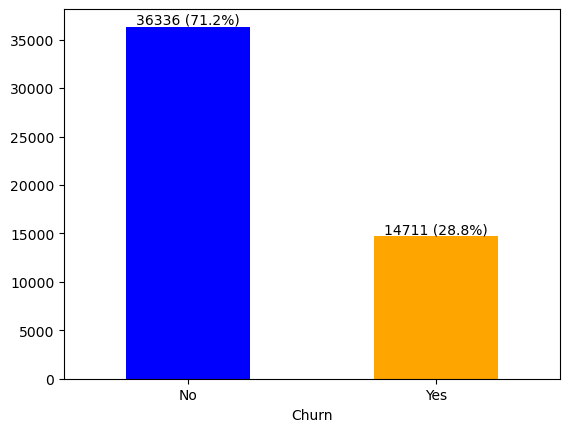

In [5]:
import matplotlib.pyplot as plt
value_counts = train['Churn'].value_counts()

# 막대 그래프 그리기
ax = value_counts.plot(kind='bar', color=['blue', 'orange'])

# 각 값의 카운트를 막대 위에 표시
def autolabel_percent(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height,
                f'{height} ({height / value_counts.sum() * 100:.1f}%)',
                ha='center', va='bottom')

autolabel_percent(ax.patches)

plt.xticks(rotation=360)
# 그래프 출력
plt.show()

~~~
- Churn 값 비교
데이터 불균형화가 심해보임.
Accuracy는 높게 나올 수 있지만 Recall, Precision 값이 더 중요한 고객 이탈 예측이라 oversampling을 통한 데이터 처리 필요

## 3. Feature Encoding

~~~
Customer ID, Service Area는 삭제

In [6]:
train = train.drop(["CustomerID", "ServiceArea"], axis=1)

In [7]:
train1 = train.copy()

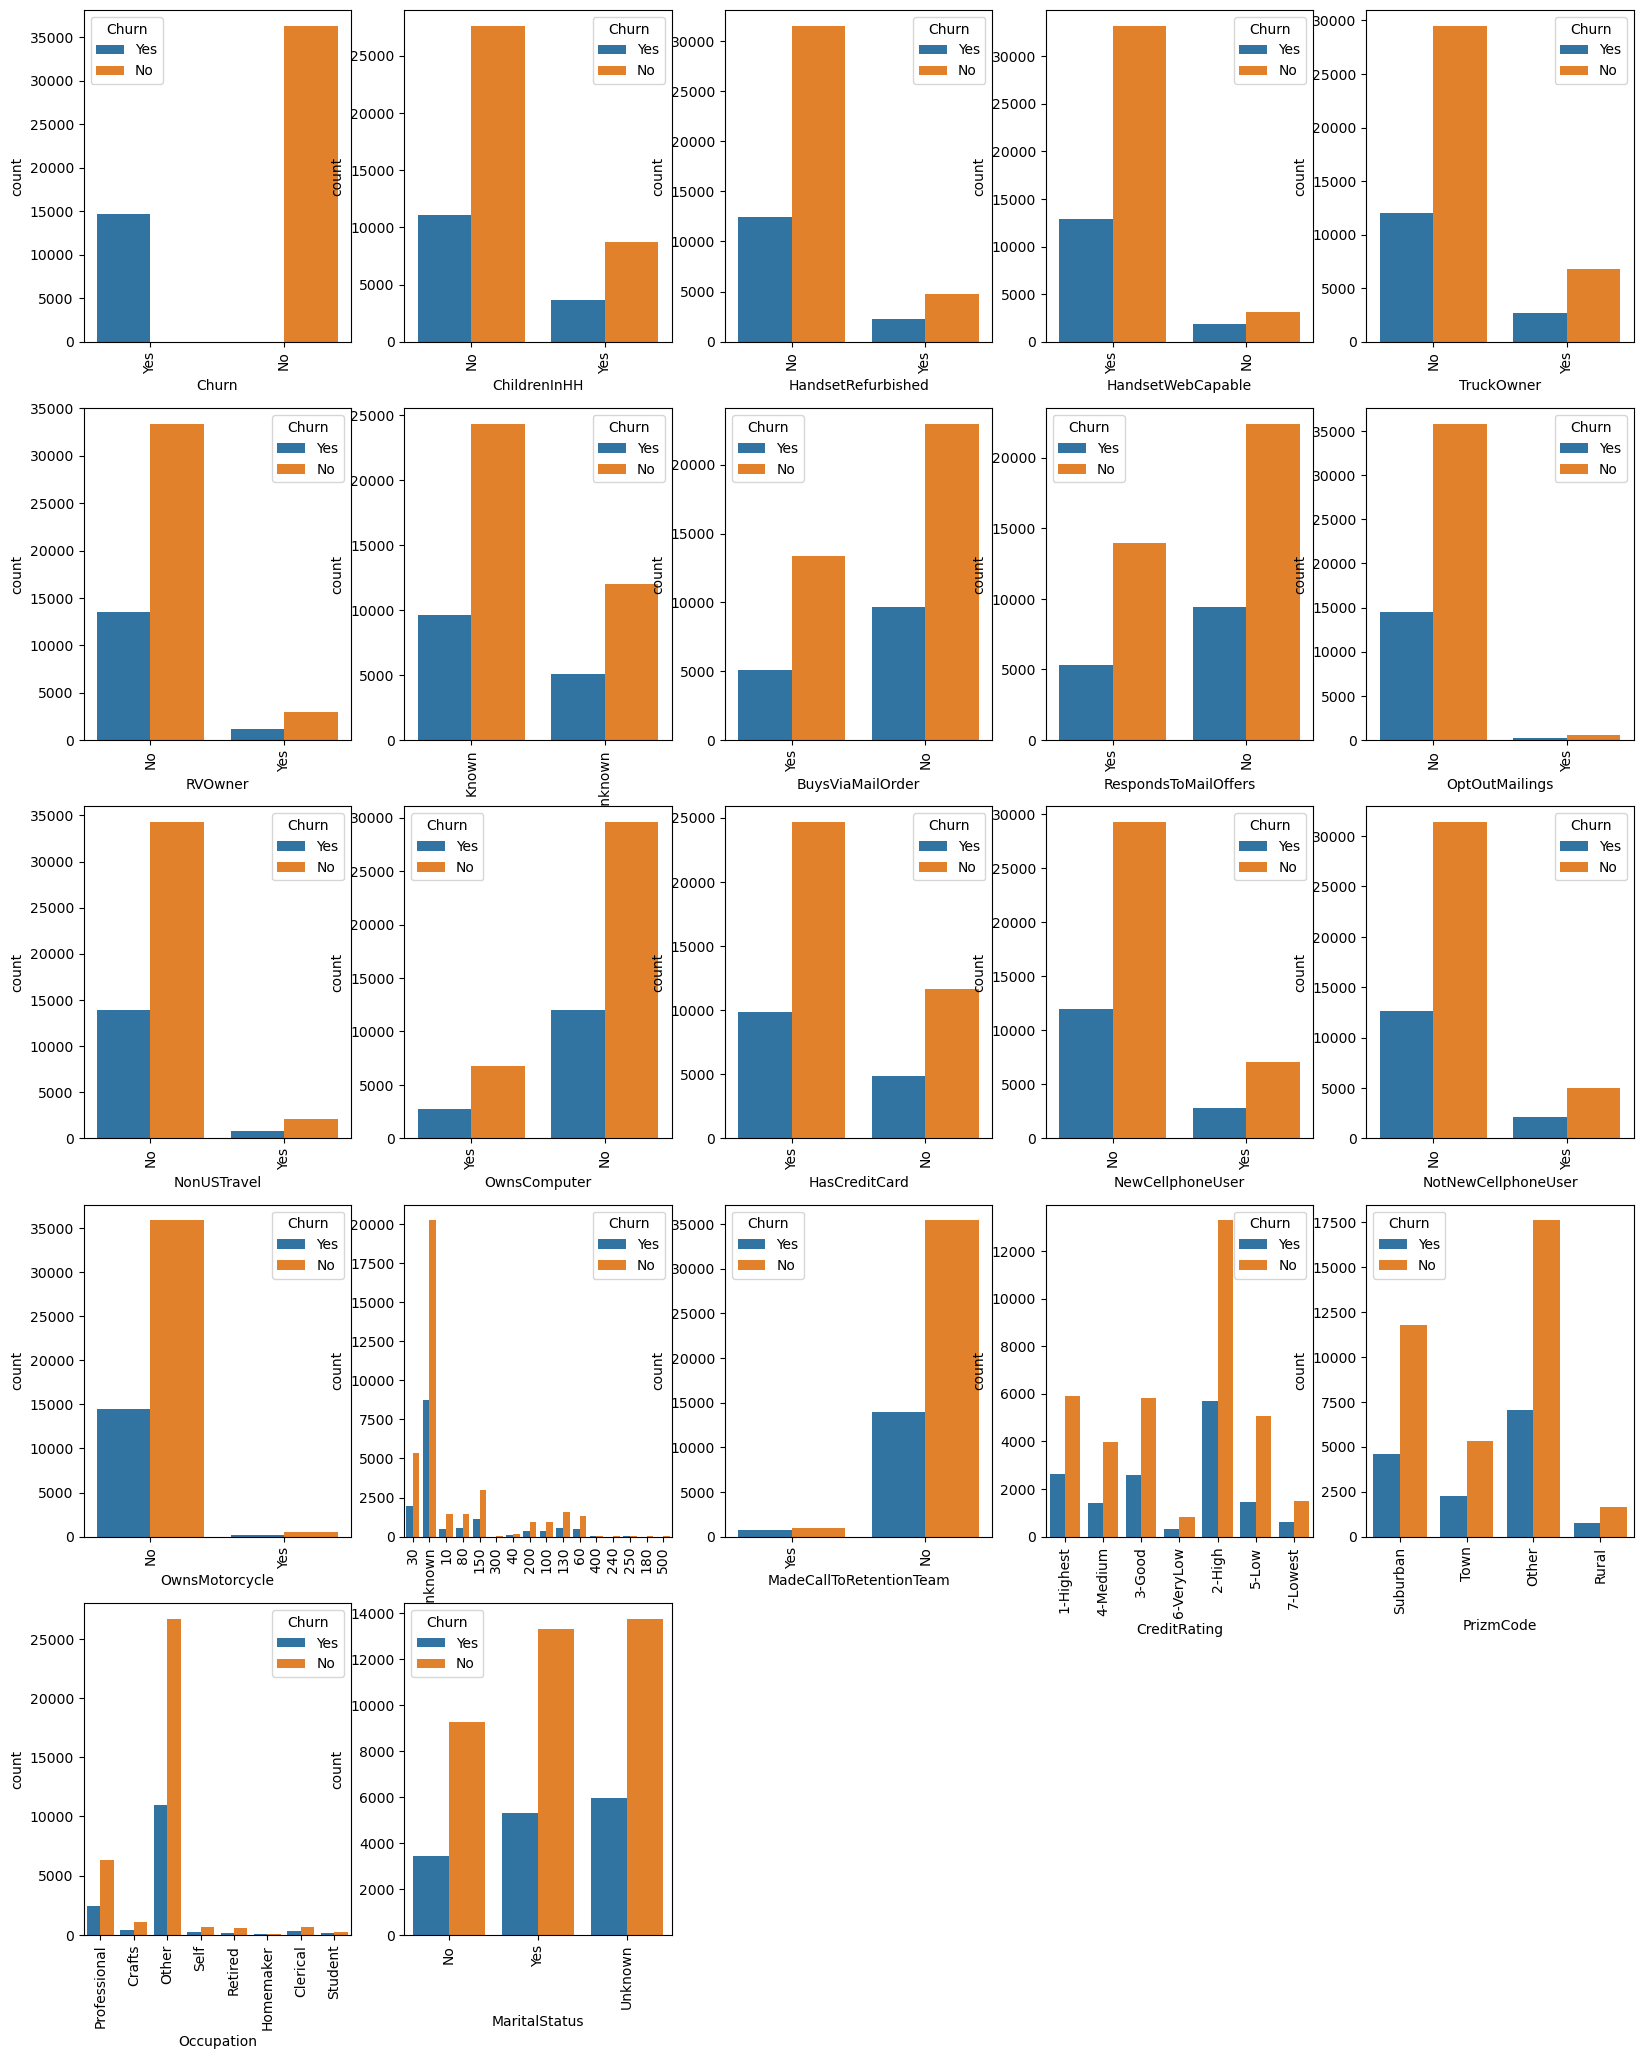

In [8]:
plots_per_row = 5

number_of_plots = train1.select_dtypes(include=['object']).shape[-1]

fig, axes = plt.subplots((number_of_plots//plots_per_row) + (number_of_plots % 5 != 0), plots_per_row)

axes = axes.flatten()

count = 0
for index, col in train1.select_dtypes(include=['object']).columns.to_series().items():
    a = sns.countplot(x=train1[col], hue=train1.Churn, ax=axes[count])
    a.tick_params(axis='x', labelrotation=90)
    count += 1
    
for i in range(1, len(axes) - number_of_plots + 1):
    fig.delaxes(axes[-i]) # 빈 subplot은 삭제
    
fig.set_figwidth(20)
fig.set_figheight(25)
plt.show()

### 3-1. Numeric Columns

In [9]:
num_col = ['MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes',
            'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues', 'DroppedCalls', 'BlockedCalls', 'UnansweredCalls',
            'CustomerCareCalls', 'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut',
            'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService', 'UniqueSubs',
            'Handsets', 'CurrentEquipmentDays']

In [10]:
train_eda = train1[num_col]

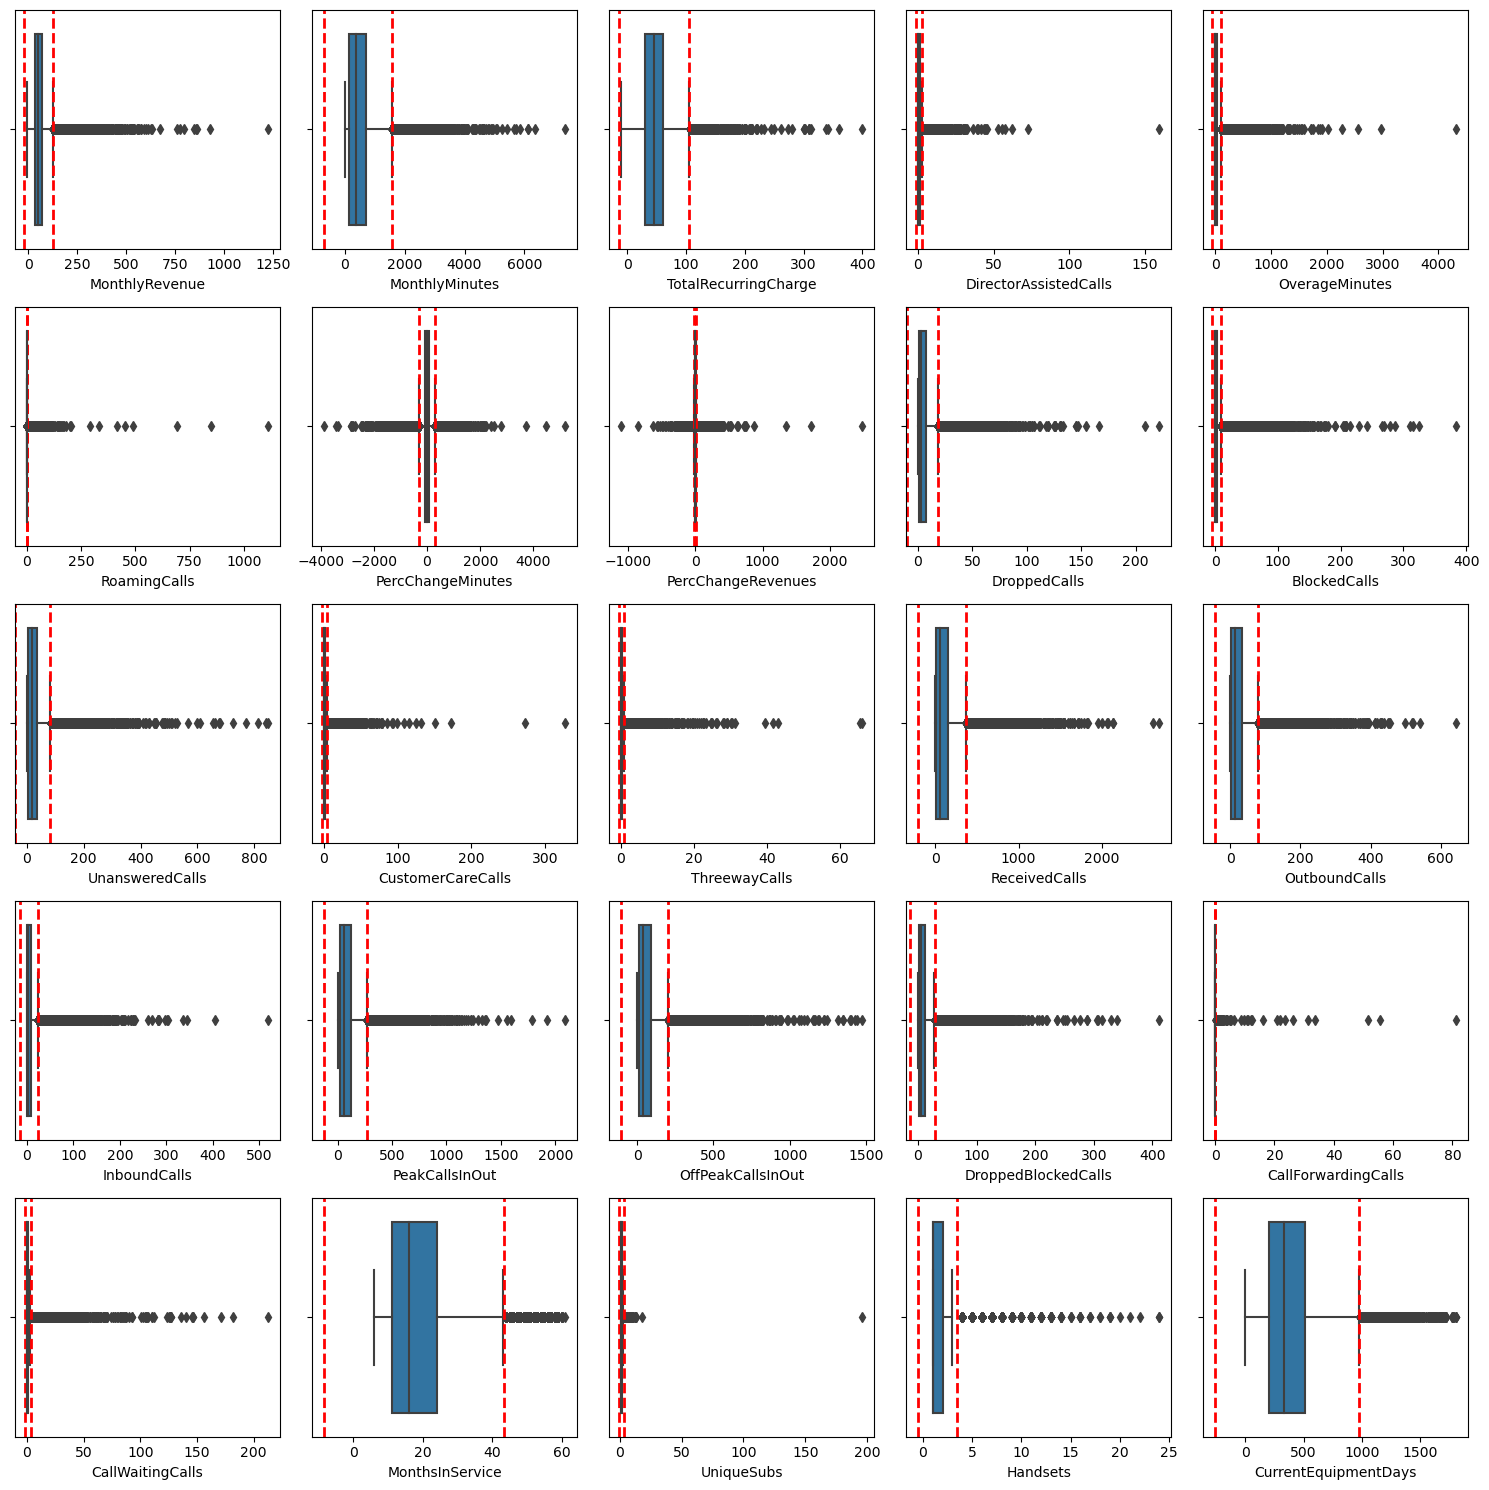

In [11]:
num_rows = 5
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

axes = axes.flatten()

for i, column in enumerate(train_eda.columns):
    sns.boxplot(x=train1[column], ax=axes[i])
    
    Q1 = train1[column].quantile(0.25)
    Q3 = train1[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_fence = Q3 + 1.5 * IQR
    lower_fence = Q1 - 1.5 * IQR
    
    axes[i].axvline(upper_fence, color='r', linestyle='--', linewidth=2)
    axes[i].axvline(lower_fence, color='r', linestyle='--', linewidth=2)

if len(train_eda.columns) < len(axes):
    for j in range(len(train_eda.columns), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

<Axes: >

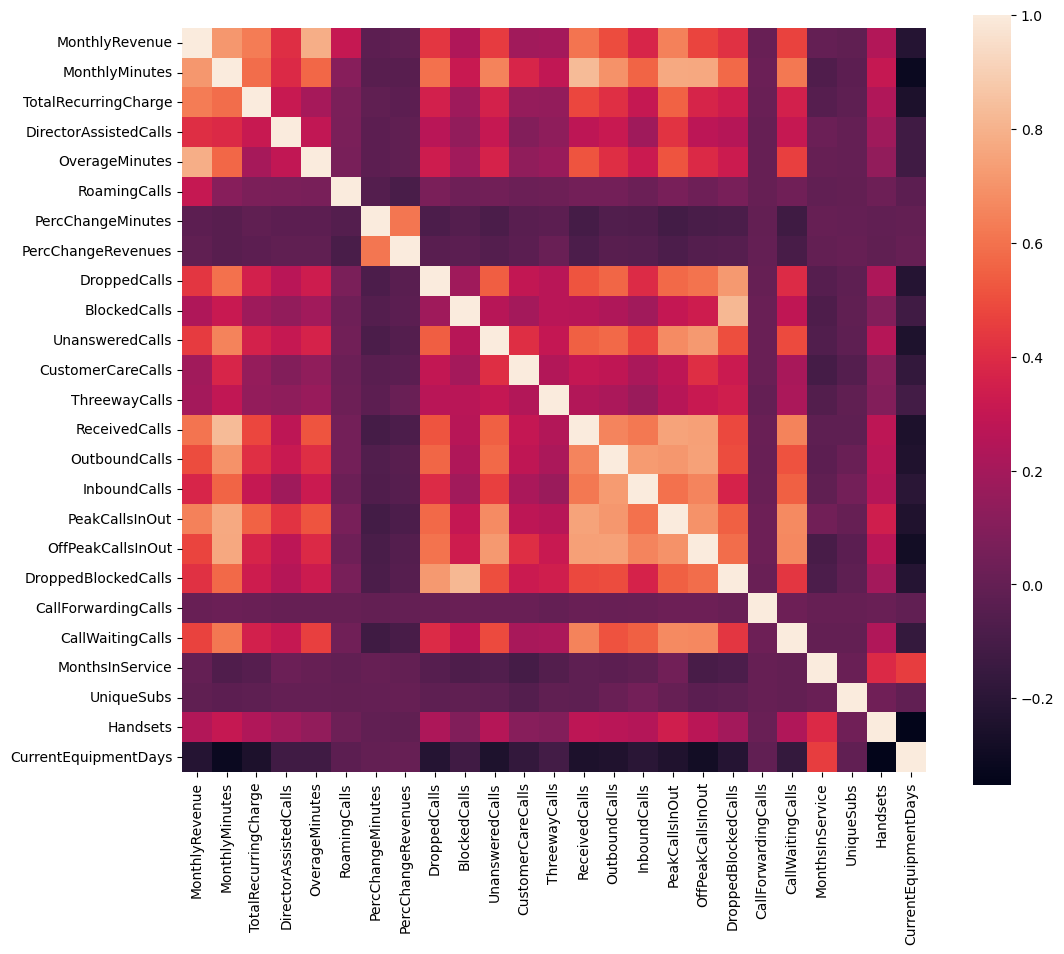

In [12]:
plt.figure(figsize=(12, 10))
cor = train_eda.corr()
sns.heatmap(cor, square = True)

# 비교를 통해 최적의 전처리 방법 찾기
~~~
1. 결측치 제거 하지 않는 데이터 (카이제곱 및 t-test를 통해 컬럼 선정)
2. 결측지 제거하지 않는 모든 데이터
3. 결측치 최빈값 및 평균으로 변경
~~~

## 1. 결측치 제거 하지 않는 데이터 (카이제곱 및 t-test를 통해 컬럼 선정)

In [13]:
train_null = train1.copy()

In [14]:
null_rows_selector = train_null.isnull().any(axis=1)
null_row_count = train_null[null_rows_selector].shape[0]

df_null = train_null.isnull().groupby(train_null.Churn).sum().transpose()
df_null['total'] = train_null.isnull().sum()
df_null['percent'] = (df_null['total'] / len(train_null)) * 100
df_null = df_null[df_null.total != 0]

print("rows with null values: ", null_row_count, ", {:.2f}%".format((null_row_count / len(train_null) * 100)))
print('columns with null values: ', df_null.shape[0])

df_null

rows with null values:  1271 , 2.49%
columns with null values:  12


Churn,No,Yes,total,percent
MonthlyRevenue,86,70,156,0.305601
MonthlyMinutes,86,70,156,0.305601
TotalRecurringCharge,86,70,156,0.305601
DirectorAssistedCalls,86,70,156,0.305601
OverageMinutes,86,70,156,0.305601
RoamingCalls,86,70,156,0.305601
PercChangeMinutes,159,208,367,0.718945
PercChangeRevenues,159,208,367,0.718945
Handsets,1,0,1,0.001959
HandsetModels,1,0,1,0.001959


In [15]:
pd.concat([train_null.Churn.value_counts(normalize=True).rename("Overall"), train_null[null_rows_selector].Churn.value_counts(normalize=True).rename("within_null_rows")], axis=1)

,Overall,within_null_rows
Churn,,
No,0.711815,0.642801
Yes,0.288185,0.357199


In [16]:
contingency_table = pd.concat([train_null.Churn.value_counts().rename("Overall"), train_null[null_rows_selector].Churn.value_counts()
                               .rename("within_null_rows")], axis=1).transpose()
contingency_table

Churn,No,Yes
Overall,36336,14711
within_null_rows,817,454


In [17]:
from scipy.stats import chi2_contingency

stat, p, dof, expected = chi2_contingency(contingency_table.values)

# p-value 확인
alpha = 0.05 # 유의값 수준
print("p value is " + str(p))

print("Dependent (reject H0)") if p <= alpha else print("Independent (H0 holds true)")

p value is 1.0070749538532247e-07
Dependent (reject H0)


In [18]:
def chi2test(X, y, alpha=0.05):
    # X: DataFrame
    # y: series
    
    target = y.name
    test_df = []
    for index, col in X.select_dtypes(include=['object']).columns.to_series().items():
        df = pd.concat([y, X[col]], axis=1)
        contingency_table = df.value_counts().rename('counts').reset_index().pivot(index=target, columns=col, values='counts').fillna(0)
        stat, p, dof, expected = chi2_contingency(contingency_table.values)
        test_df.append([target, col, stat, p, 
                      'Dependent (reject H0)' if p <= alpha else 'Independent (H0 holds true)','include' if p <= alpha else 'drop'])
        
    test_df = pd.DataFrame(test_df, columns=["variable1", "variable2", "chi2-stat", "p-value", "result", "recommendation"])
    return test_df

chi2test(train_null.drop('Churn', axis=1), train_null['Churn'])

,variable1,variable2,chi2-stat,p-value,result,recommendation
0,Churn,ChildrenInHH,4.618176,3.163486e-02,Dependent (reject H0),include
1,Churn,HandsetRefurbished,45.595205,1.453971e-11,Dependent (reject H0),include
2,Churn,HandsetWebCapable,196.373257,1.292123e-44,Dependent (reject H0),include
3,Churn,TruckOwner,1.157607,2.819623e-01,Independent (H0 holds true),drop
4,Churn,RVOwner,0.581561,4.457013e-01,Independent (H0 holds true),drop
5,Churn,Homeownership,8.783314,3.039984e-03,Dependent (reject H0),include
6,Churn,BuysViaMailOrder,23.993398,9.666660e-07,Dependent (reject H0),include
7,Churn,RespondsToMailOffers,26.688591,2.390287e-07,Dependent (reject H0),include
8,Churn,OptOutMailings,0.000000,1.000000e+00,Independent (H0 holds true),drop
9,Churn,NonUSTravel,0.413813,5.200405e-01,Independent (H0 holds true),drop


In [19]:
from scipy.stats import ttest_ind

def t_test(X, y, alpha=0.05):
    target = y.name
    print('t_test with alpha', alpha)
    test_df = []
    for index, col in X.select_dtypes(exclude=['object']).columns.to_series().items():
        df = pd.concat([y, X[col]], axis=1)
        ttest_df = df.set_index(target, drop=True).fillna(0)

        stat, p = ttest_ind(ttest_df.loc["Yes"], ttest_df.loc["No"], equal_var=False)
        test_df.append([target, col, stat, p,
                     'Dependent (reject H0)' if p <= alpha else 'Independent (H0 holds true)', 'include' if p <= alpha else 'drop'])

    test_df = pd.DataFrame(test_df, columns=['variable1', 'variable2', 't-test', 'p-value', 'result', 'recommendation'])
    return test_df

t_test(train_null.drop('Churn', axis=1), train_null['Churn'])

t_test with alpha 0.05


,variable1,variable2,t-test,p-value,result,recommendation
0,Churn,MonthlyRevenue,[-3.0178789820785163],[0.0025478602791834805],Dependent (reject H0),include
1,Churn,MonthlyMinutes,[-11.877849954853874],[1.835797057997502e-32],Dependent (reject H0),include
2,Churn,TotalRecurringCharge,[-14.52160176239891],[1.310521238648181e-47],Dependent (reject H0),include
3,Churn,DirectorAssistedCalls,[-4.8450245034580215],[1.2718380411479793e-06],Dependent (reject H0),include
4,Churn,OverageMinutes,[3.687404466662035],[0.00022697324858136802],Dependent (reject H0),include
5,Churn,RoamingCalls,[2.244494743224252],[0.024809892182594908],Dependent (reject H0),include
6,Churn,PercChangeMinutes,[-7.448350298200055],[9.747511469363198e-14],Dependent (reject H0),include
7,Churn,PercChangeRevenues,[2.282802936514573],[0.02245132129026346],Dependent (reject H0),include
8,Churn,DroppedCalls,[-3.5273600982343885],[0.00042039591089024496],Dependent (reject H0),include
9,Churn,BlockedCalls,[-1.2668362619480196],[0.20522435968477423],Independent (H0 holds true),drop


### 1.1. include recommendation이 된 컬럼만 선정하여 train_null_1 재정의

In [20]:
train_null_1 = train_null[['ChildrenInHH', 'HandsetRefurbished','HandsetWebCapable', 'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers', 'HandsetPrice', 'MadeCallToRetentionTeam',
                'CreditRating', 'PrizmCode', 'MaritalStatus', 'MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls', 'PercChangeMinutes',
                'PercChangeRevenues', 'DroppedCalls', 'UnansweredCalls', 'CustomerCareCalls', 'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut', 'OffPeakCallsInOut',
                'DroppedBlockedCalls', 'CallWaitingCalls', 'MonthsInService', 'UniqueSubs', 'ActiveSubs', 'Handsets', 'HandsetModels', 'CurrentEquipmentDays', 'RetentionCalls', 'RetentionOffersAccepted',
                'ReferralsMadeBySubscriber', 'IncomeGroup', 'AdjustmentsToCreditRating', 'Age','Churn']]

#### Binary Column 0과 1로 변경

In [21]:
binary_cols = ['ChildrenInHH', 'HandsetRefurbished','HandsetWebCapable', 'BuysViaMailOrder',
               'RespondsToMailOffers', 'HandsetPrice', 'MadeCallToRetentionTeam','Churn']
for i in binary_cols :
    train_null_1[i] = train_null_1[i].replace({'Yes' : 1, 'No' : 0})

train_null_1['Homeownership'] = train_null_1['Homeownership'].replace({"Known" : 1, "Unknown" : 0})

In [22]:
train_null_1.head(1)

,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,Homeownership,BuysViaMailOrder,RespondsToMailOffers,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,...,Handsets,HandsetModels,CurrentEquipmentDays,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating,Age,Churn
0,0,0,1,1,1,1,30,1,1-Highest,Suburban,...,2.0,2.0,361.0,1,0,0,4,0,31.0,1


### Category Columns

In [23]:
train_cat = train_null_1[['CreditRating', 'PrizmCode', 'MaritalStatus']]
le = LabelEncoder()
le_train_cat = train_cat.apply(le.fit_transform)

In [24]:
le_train_cat.head(1)

,CreditRating,PrizmCode,MaritalStatus
0,0,2,0


In [25]:
train_null_1[['CreditRating', 'PrizmCode', 'MaritalStatus']] = le_train_cat[['CreditRating', 'PrizmCode', 'MaritalStatus']]

In [26]:
# Unkown 값은 평균치로 변경
mean_price = train_null_1.loc[train_null_1['HandsetPrice'] != 'Unknown', 'HandsetPrice'].astype(float).mean()

train_null_1.loc[train_null_1['HandsetPrice'] == 'Unknown', 'HandsetPrice'] = mean_price

In [27]:
cor = train_null_1.corr()

abs_correlation_with_churn = cor['Churn'].abs().sort_values(ascending=False)

for column, correlation in abs_correlation_with_churn.items():
    if column != 'Churn':
        print(f"'{column}': {correlation}")

'CurrentEquipmentDays': 0.10368781273223122
'MadeCallToRetentionTeam': 0.06739314671419709
'RetentionCalls': 0.06530063726408082
'HandsetWebCapable': 0.0620962188050375
'TotalRecurringCharge': 0.06129634005884528
'MonthlyMinutes': 0.05016619877177656
'CreditRating': 0.044750094869634785
'OffPeakCallsInOut': 0.040783780171258555
'HandsetModels': 0.04004750692203107
'PeakCallsInOut': 0.04002890706579177
'ReceivedCalls': 0.037452800090243585
'CustomerCareCalls': 0.035509879238917054
'RetentionOffersAccepted': 0.03495335051443715
'UniqueSubs': 0.03452223565240581
'InboundCalls': 0.03423242192280207
'PercChangeMinutes': 0.03420242393090432
'Handsets': 0.03284548777953606
'OutboundCalls': 0.03227612075144681
'HandsetRefurbished': 0.02994898968796429
'UnansweredCalls': 0.029350162765353637
'Age': 0.026154597812084446
'CallWaitingCalls': 0.025652577782318182
'ThreewayCalls': 0.023854164611368446
'RespondsToMailOffers': 0.022909974940587278
'BuysViaMailOrder': 0.021725089408201118
'DirectorAssi

In [28]:
len(train_null_1.columns)

43

In [29]:
train_null_1.isnull().sum().sort_values(ascending=False)

Age                          909
PercChangeMinutes            367
PercChangeRevenues           367
MonthlyMinutes               156
OverageMinutes               156
DirectorAssistedCalls        156
TotalRecurringCharge         156
MonthlyRevenue               156
RoamingCalls                 156
HandsetModels                  1
Handsets                       1
CurrentEquipmentDays           1
ActiveSubs                     0
UniqueSubs                     0
MonthsInService                0
CallWaitingCalls               0
DroppedBlockedCalls            0
ChildrenInHH                   0
PeakCallsInOut                 0
RetentionCalls                 0
RetentionOffersAccepted        0
ReferralsMadeBySubscriber      0
IncomeGroup                    0
AdjustmentsToCreditRating      0
OffPeakCallsInOut              0
CustomerCareCalls              0
InboundCalls                   0
CreditRating                   0
HandsetWebCapable              0
Homeownership                  0
BuysViaMai

In [30]:
train_null_1 = train_null_1.dropna()

In [31]:
train_null_1.isnull().sum().sort_values(ascending=False)

ChildrenInHH                 0
ActiveSubs                   0
OutboundCalls                0
InboundCalls                 0
PeakCallsInOut               0
OffPeakCallsInOut            0
DroppedBlockedCalls          0
CallWaitingCalls             0
MonthsInService              0
UniqueSubs                   0
Handsets                     0
ThreewayCalls                0
HandsetModels                0
CurrentEquipmentDays         0
RetentionCalls               0
RetentionOffersAccepted      0
ReferralsMadeBySubscriber    0
IncomeGroup                  0
AdjustmentsToCreditRating    0
Age                          0
ReceivedCalls                0
CustomerCareCalls            0
HandsetRefurbished           0
MaritalStatus                0
HandsetWebCapable            0
Homeownership                0
BuysViaMailOrder             0
RespondsToMailOffers         0
HandsetPrice                 0
MadeCallToRetentionTeam      0
CreditRating                 0
PrizmCode                    0
MonthlyR

## 2. 결측지 제거하지 않는 모든 데이터

In [32]:
trian_with_null = train1.copy()

In [33]:
numeric_columns = trian_with_null.select_dtypes(include="number").columns

print(numeric_columns)

Index(['MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge',
       'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls',
       'PercChangeMinutes', 'PercChangeRevenues', 'DroppedCalls',
       'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls', 'ThreewayCalls',
       'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut',
       'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallForwardingCalls',
       'CallWaitingCalls', 'MonthsInService', 'UniqueSubs', 'ActiveSubs',
       'Handsets', 'HandsetModels', 'CurrentEquipmentDays', 'RetentionCalls',
       'RetentionOffersAccepted', 'ReferralsMadeBySubscriber', 'IncomeGroup',
       'AdjustmentsToCreditRating', 'Age'],
      dtype='object')


In [34]:
binary_columns = trian_with_null.columns[(trian_with_null.nunique() == 2) & (trian_with_null.dtypes == "object")]

print(binary_columns)

Index(['Churn', 'ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable',
       'TruckOwner', 'RVOwner', 'Homeownership', 'BuysViaMailOrder',
       'RespondsToMailOffers', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer',
       'HasCreditCard', 'NewCellphoneUser', 'NotNewCellphoneUser',
       'OwnsMotorcycle', 'MadeCallToRetentionTeam'],
      dtype='object')


In [35]:
for i in binary_columns :
    trian_with_null[i] = trian_with_null[i].replace({'Yes' : 1, 'No' : 0})

trian_with_null['Homeownership'] = trian_with_null['Homeownership'].replace({"Known" : 1, "Unknown" : 0})

In [36]:
categorical_columns = trian_with_null[['CreditRating', 'PrizmCode', 'Occupation', 'MaritalStatus']]
train_with_null_cat = trian_with_null.apply(le.fit_transform)


In [37]:
trian_with_null[['CreditRating', 'PrizmCode', 'Occupation', 'MaritalStatus']] = train_with_null_cat[['CreditRating', 'PrizmCode', 'Occupation', 'MaritalStatus']]

In [38]:
mean_price = trian_with_null.loc[trian_with_null['HandsetPrice'] != 'Unknown', 'HandsetPrice'].astype(float).mean()

trian_with_null.loc[trian_with_null['HandsetPrice'] == 'Unknown', 'HandsetPrice'] = mean_price

In [39]:
cor = trian_with_null.corr()

abs_correlation_with_churn = cor['Churn'].abs().sort_values(ascending=False)

for column, correlation in abs_correlation_with_churn.items():
    if column != 'Churn':
        print(f"'{column}': {correlation}")

'CurrentEquipmentDays': 0.10368781273223118
'MadeCallToRetentionTeam': 0.06739314671419708
'RetentionCalls': 0.06530063726408084
'HandsetWebCapable': 0.062096218805037476
'TotalRecurringCharge': 0.061296340058845274
'MonthlyMinutes': 0.05016619877177655
'CreditRating': 0.04475009486963481
'OffPeakCallsInOut': 0.04078378017125855
'HandsetModels': 0.040047506922031066
'PeakCallsInOut': 0.040028907065791736
'ReceivedCalls': 0.037452800090243585
'CustomerCareCalls': 0.035509879238917054
'RetentionOffersAccepted': 0.03495335051443715
'UniqueSubs': 0.03452223565240581
'InboundCalls': 0.03423242192280206
'PercChangeMinutes': 0.03420242393090433
'Handsets': 0.03284548777953603
'OutboundCalls': 0.032276120751446806
'HandsetRefurbished': 0.029948989687964275
'UnansweredCalls': 0.02935016276535365
'Age': 0.026154597812084453
'CallWaitingCalls': 0.025652577782318175
'ThreewayCalls': 0.023854164611368453
'RespondsToMailOffers': 0.022909974940587288
'BuysViaMailOrder': 0.021725089408201118
'Director

In [40]:
trian_with_null.isnull().sum().sort_values(ascending=False)

Age                          909
PercChangeMinutes            367
PercChangeRevenues           367
MonthlyMinutes               156
TotalRecurringCharge         156
DirectorAssistedCalls        156
OverageMinutes               156
RoamingCalls                 156
MonthlyRevenue               156
Handsets                       1
HandsetModels                  1
CurrentEquipmentDays           1
CustomerCareCalls              0
ReferralsMadeBySubscriber      0
OptOutMailings                 0
NonUSTravel                    0
OwnsComputer                   0
HasCreditCard                  0
RetentionCalls                 0
RetentionOffersAccepted        0
NewCellphoneUser               0
NotNewCellphoneUser            0
IncomeGroup                    0
BuysViaMailOrder               0
OwnsMotorcycle                 0
AdjustmentsToCreditRating      0
HandsetPrice                   0
MadeCallToRetentionTeam        0
CreditRating                   0
PrizmCode                      0
Occupation

In [41]:
len(trian_with_null.columns)

55

In [42]:
trian_with_null = trian_with_null.dropna()
trian_with_null.isnull().sum().sort_values(ascending=False)

Churn                        0
RetentionOffersAccepted      0
HandsetWebCapable            0
TruckOwner                   0
RVOwner                      0
Homeownership                0
BuysViaMailOrder             0
RespondsToMailOffers         0
OptOutMailings               0
NonUSTravel                  0
OwnsComputer                 0
HasCreditCard                0
RetentionCalls               0
NewCellphoneUser             0
ChildrenInHH                 0
NotNewCellphoneUser          0
ReferralsMadeBySubscriber    0
IncomeGroup                  0
OwnsMotorcycle               0
AdjustmentsToCreditRating    0
HandsetPrice                 0
MadeCallToRetentionTeam      0
CreditRating                 0
PrizmCode                    0
Occupation                   0
MaritalStatus                0
HandsetRefurbished           0
CurrentEquipmentDays         0
MonthlyRevenue               0
ThreewayCalls                0
MonthlyMinutes               0
TotalRecurringCharge         0
Director

## 3. 결측치 최빈값 및 평균으로 변경하고 모든 값을 사용

In [43]:
train_not_null = trian_with_null.copy()

In [44]:
def fill_missing_values(df):
    for col in df.columns:
        if df[col].dtype == float or df[col].dtype == int:
            mean = df[col].mean()
            df[col].fillna(mean, inplace=True)
        elif df[col].dtype == object:
            mode = df[col].mode().iloc[0]
            df[col].fillna(mode, inplace=True)
        else:
            continue
        
    return df

train_not_null= fill_missing_values(train_not_null)

In [45]:
train_not_null.isnull().sum().sort_values(ascending=False)

Churn                        0
RetentionOffersAccepted      0
HandsetWebCapable            0
TruckOwner                   0
RVOwner                      0
Homeownership                0
BuysViaMailOrder             0
RespondsToMailOffers         0
OptOutMailings               0
NonUSTravel                  0
OwnsComputer                 0
HasCreditCard                0
RetentionCalls               0
NewCellphoneUser             0
ChildrenInHH                 0
NotNewCellphoneUser          0
ReferralsMadeBySubscriber    0
IncomeGroup                  0
OwnsMotorcycle               0
AdjustmentsToCreditRating    0
HandsetPrice                 0
MadeCallToRetentionTeam      0
CreditRating                 0
PrizmCode                    0
Occupation                   0
MaritalStatus                0
HandsetRefurbished           0
CurrentEquipmentDays         0
MonthlyRevenue               0
ThreewayCalls                0
MonthlyMinutes               0
TotalRecurringCharge         0
Director

In [46]:
len(train_not_null.columns)

55

# 이상치 제거 3가지 데이터 비교
~~~
Standard Sclaer 이상치에 민감하게 반응
Robust Scaler 이상치에 상대적으로 민감하게 반응하지 않는다.


3가지 데이터셋
1. 카이제곱 및 t-test를 통해 컬럼 선정 결측치는 모두 drop - train_null_1
2. 결측지 모두 제거 - trian_with_null
3. 결측치 최빈값 및 평균으로 변경 - train_not_null
~~~

#### Scaler data로 만드는 함수

In [47]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

def scale_data_with_standard_scaler(data):
    ss = StandardScaler()
    scaled_data = pd.DataFrame(ss.fit_transform(data), columns=data.columns)
    return scaled_data


#### Robust data로 만드는 함수

In [48]:
from sklearn.preprocessing import RobustScaler
import pandas as pd

def scale_data_with_robust_scaler(data):
    rs = RobustScaler()
    scaled_data = pd.DataFrame(rs.fit_transform(data), columns=data.columns)
    return scaled_data

#### isolation forest를 사용해 이상치를 표시하고 pca로 나타내는 함수

In [49]:
from collections import Counter
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def detect_outliers_and_plot_pca(data, n_estimators=100, max_samples="auto", contamination=0.01, max_features=1, bootstrap=False, n_jobs=1, random_state=None, verbose=0):
    # Isolation Forest 모델 생성
    clf = IsolationForest(n_estimators=n_estimators, max_samples=max_samples, contamination=contamination,
                          max_features=max_features, bootstrap=bootstrap, n_jobs=n_jobs, random_state=random_state, verbose=verbose)

    # 데이터셋 학습
    clf.fit(data)

    # 이상치 예측
    y_pred_outliers = clf.predict(data)

    # 이상치 개수 카운트
    outlier_count = Counter(y_pred_outliers)

    # 원본 DataFrame에 이상치 정보 추가
    data['out'] = y_pred_outliers

    # 이상치가 있는 행(index) 추출
    outliers = data.loc[data['out'] == -1]
    outlier_index = list(outliers.index)

    # PCA 변환
    pca = PCA(2)
    res = pd.DataFrame(pca.fit_transform(data))
    Z = np.array(res)

    # 이상치 플롯
    plt.title("IsolationForest")
    b1 = plt.scatter(res[0], res[1], c='green', s=20, label="normal points")
    b1 = plt.scatter(res.iloc[outlier_index, 0], res.iloc[outlier_index, 1], c='green', s=20, edgecolor="red", label="predicted outliers")
    plt.legend(loc="upper right")
    plt.show()

    return outlier_index, outlier_count

#### 3d로 나타내는 함수

In [50]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def plot_outliers_pca_3d(data, outlier_index):
    pca = PCA(n_components=3)
    X_reduce = pca.fit_transform(data)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_zlabel("x_composite_3")
    
    ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers", c="green")
    
    ax.scatter(X_reduce[outlier_index, 0], X_reduce[outlier_index, 1], X_reduce[outlier_index, 2],
               lw=2, s=60, marker="x", c="red", label="outliers")
    
    ax.legend()
    plt.show()

## train_null_1

### Standard Scaler

In [51]:
train_null_1_ss = scale_data_with_standard_scaler(train_null_1)
train_null_1_ss.head(1)

,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,Homeownership,BuysViaMailOrder,RespondsToMailOffers,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,...,Handsets,HandsetModels,CurrentEquipmentDays,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating,Age,Churn
0,-0.572308,-0.401295,0.328528,0.689248,1.309676,1.267471,-1.317407,5.448673,-1.188583,0.727084,...,0.146509,0.487084,-0.075323,4.775682,-0.128369,-0.193114,-0.129667,-0.140258,0.225784,1.578397


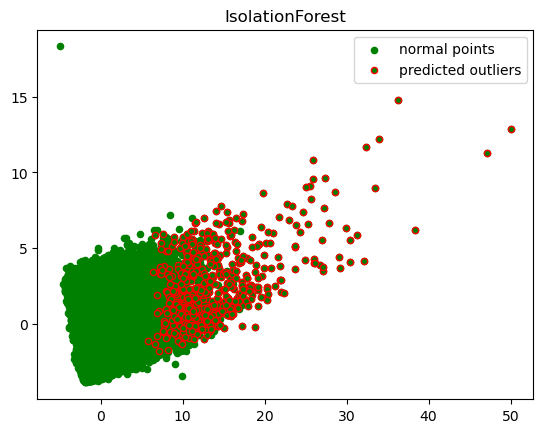

이상치 개수: Counter({1: 49278, -1: 498})
이상치 인덱스: [41, 50, 73, 76, 82, 87, 108, 114, 128, 139, 155, 204, 208, 230, 235, 241, 257, 269, 286, 291, 293, 321, 328, 344, 348, 367, 369, 463, 464, 476, 504, 530, 532, 635, 659, 696, 794, 831, 833, 865, 887, 939, 953, 959, 979, 1065, 1098, 1129, 1165, 1206, 1210, 1221, 1270, 1286, 1428, 1473, 1486, 1570, 1572, 1846, 1949, 2011, 2092, 2109, 2222, 2272, 2337, 2470, 2472, 2506, 2511, 2585, 2632, 2718, 2875, 3084, 3318, 3434, 3609, 3708, 3785, 4010, 4041, 4105, 4128, 4197, 4207, 4221, 4231, 4254, 4287, 4459, 4690, 4701, 4920, 4963, 5106, 5148, 5267, 5342, 5359, 5832, 5931, 5933, 6228, 6407, 6599, 6649, 6658, 6700, 6724, 6875, 6920, 7075, 7149, 7270, 7398, 7418, 7455, 7478, 7564, 7571, 7630, 7665, 7775, 7792, 8056, 8715, 9050, 9090, 9201, 9338, 9350, 9405, 9864, 9879, 10090, 10276, 10296, 10398, 10564, 10567, 10578, 10726, 10728, 10830, 11026, 11049, 11215, 11258, 11304, 11332, 11406, 11490, 11600, 11626, 11884, 11951, 11997, 12012, 12064, 12100, 12126,

In [52]:
outlier_index, outlier_count = detect_outliers_and_plot_pca(train_null_1_ss, n_estimators=100, contamination=0.01)
print("이상치 개수:", outlier_count)
print("이상치 인덱스:", outlier_index)

In [53]:
train_null_1_ss['Churn'] = train1["Churn"]

In [54]:
train_null_1_ss.isnull().sum().sort_values(ascending=False)

ChildrenInHH                 0
HandsetRefurbished           0
OutboundCalls                0
InboundCalls                 0
PeakCallsInOut               0
OffPeakCallsInOut            0
DroppedBlockedCalls          0
CallWaitingCalls             0
MonthsInService              0
UniqueSubs                   0
ActiveSubs                   0
Handsets                     0
HandsetModels                0
CurrentEquipmentDays         0
RetentionCalls               0
RetentionOffersAccepted      0
ReferralsMadeBySubscriber    0
IncomeGroup                  0
AdjustmentsToCreditRating    0
Age                          0
Churn                        0
ReceivedCalls                0
ThreewayCalls                0
CustomerCareCalls            0
MaritalStatus                0
HandsetWebCapable            0
Homeownership                0
BuysViaMailOrder             0
RespondsToMailOffers         0
HandsetPrice                 0
MadeCallToRetentionTeam      0
CreditRating                 0
PrizmCod

In [55]:
train_null_1_ss = train_null_1_ss[train_null_1_ss['out'] != -1]

### Robust Scaler

In [56]:
train_null_1_rs = scale_data_with_robust_scaler(train_null_1)
train_null_1_rs.head(1)

,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,Homeownership,BuysViaMailOrder,RespondsToMailOffers,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,...,Handsets,HandsetModels,CurrentEquipmentDays,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating,Age,Churn
0,0.0,0.0,0.0,0.0,1.0,1.0,-23.342041,1.0,-0.5,0.5,...,1.0,1.0,0.1,1.0,0.0,0.0,-0.166667,0.0,0.113636,1.0


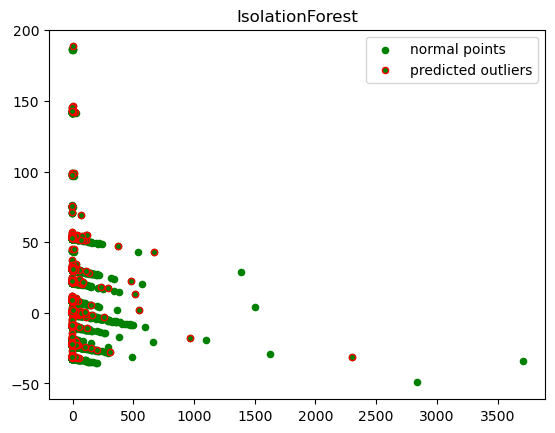

이상치 개수: Counter({1: 49278, -1: 498})
이상치 인덱스: [11, 15, 50, 73, 76, 82, 108, 114, 128, 139, 155, 204, 208, 230, 235, 241, 257, 269, 286, 291, 293, 328, 344, 348, 367, 369, 464, 476, 494, 504, 530, 532, 696, 783, 794, 831, 833, 865, 887, 901, 939, 953, 959, 979, 1065, 1129, 1165, 1206, 1210, 1270, 1286, 1312, 1428, 1463, 1470, 1486, 1516, 1572, 1846, 1949, 2011, 2092, 2109, 2146, 2222, 2272, 2337, 2470, 2472, 2511, 2522, 2585, 2632, 2636, 2695, 2875, 3084, 3113, 3131, 3163, 3387, 3477, 3609, 3708, 3785, 4010, 4105, 4207, 4221, 4231, 4254, 4287, 4459, 4690, 4701, 5106, 5148, 5157, 5224, 5267, 5438, 5442, 5611, 5832, 5867, 5931, 6388, 6407, 6649, 6658, 6700, 6724, 6875, 6920, 6933, 7075, 7105, 7146, 7149, 7270, 7398, 7455, 7478, 7495, 7564, 7571, 7630, 7665, 7792, 7983, 8056, 8125, 8215, 8703, 8736, 8924, 9090, 9135, 9201, 9338, 9350, 9405, 10276, 10486, 10564, 10726, 10830, 11026, 11049, 11215, 11258, 11304, 11332, 11406, 11490, 11600, 11623, 11626, 11951, 11997, 12039, 12064, 12100, 1210

In [57]:
outlier_index, outlier_count = detect_outliers_and_plot_pca(train_null_1_rs, n_estimators=100, contamination=0.01)
print("이상치 개수:", outlier_count)
print("이상치 인덱스:", outlier_index)

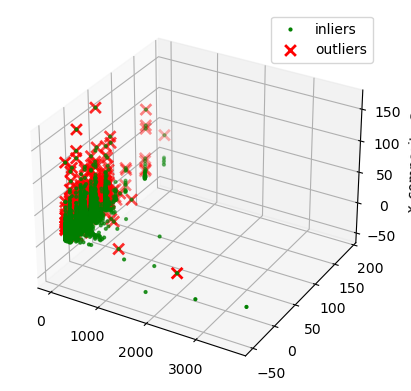

In [58]:
plot_outliers_pca_3d(train_null_1_rs, outlier_index)

In [59]:
train_null_1_rs = train_null_1_rs[train_null_1_rs['out'] != -1]

## trian_with_null

### Standard Scaler

In [60]:
trian_with_null_ss = scale_data_with_standard_scaler(trian_with_null)

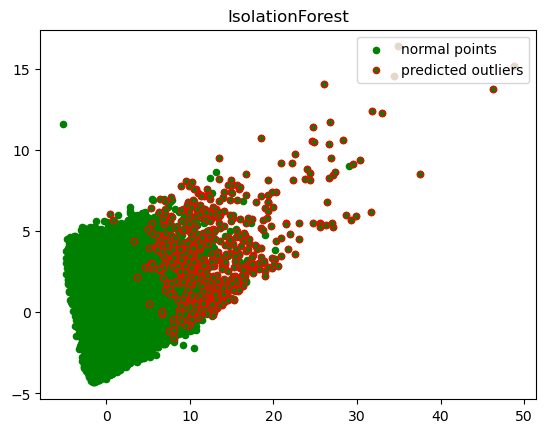

이상치 개수: Counter({1: 49278, -1: 498})
이상치 인덱스: [41, 50, 73, 76, 82, 98, 104, 108, 114, 128, 139, 153, 155, 204, 208, 230, 235, 241, 257, 269, 286, 291, 292, 293, 328, 344, 348, 359, 367, 369, 464, 476, 494, 504, 532, 635, 659, 696, 783, 794, 865, 887, 939, 959, 979, 1065, 1129, 1132, 1210, 1270, 1286, 1473, 1486, 1846, 2011, 2069, 2092, 2109, 2250, 2272, 2302, 2337, 2511, 2585, 2632, 2718, 2875, 3084, 3131, 3318, 3434, 3609, 3837, 4041, 4105, 4128, 4207, 4221, 4231, 4254, 4287, 4388, 4690, 4701, 4935, 5019, 5106, 5148, 5267, 5342, 5442, 5832, 5902, 5931, 6228, 6407, 6700, 6724, 6844, 6875, 6898, 6920, 6933, 7075, 7209, 7293, 7398, 7455, 7478, 7495, 7564, 7571, 7630, 7646, 7792, 7892, 7983, 8055, 8056, 8125, 8736, 9090, 9129, 9201, 9350, 9405, 9496, 9609, 9861, 10442, 10503, 10564, 10567, 10726, 10728, 10830, 11026, 11049, 11108, 11215, 11258, 11304, 11305, 11332, 11406, 11600, 11626, 11997, 12012, 12100, 12126, 12186, 12212, 12358, 12565, 12746, 13063, 13073, 13200, 13318, 13448, 13498,

In [61]:
outlier_index, outlier_count = detect_outliers_and_plot_pca(trian_with_null_ss, n_estimators=100, contamination=0.01)
print("이상치 개수:", outlier_count)
print("이상치 인덱스:", outlier_index)


In [62]:
trian_with_null_ss['Churn'] = train1["Churn"]
trian_with_null_ss = trian_with_null_ss[trian_with_null_ss['out'] != -1]

### Robust Scaler

In [63]:
trian_with_null_rs = scale_data_with_robust_scaler(trian_with_null)

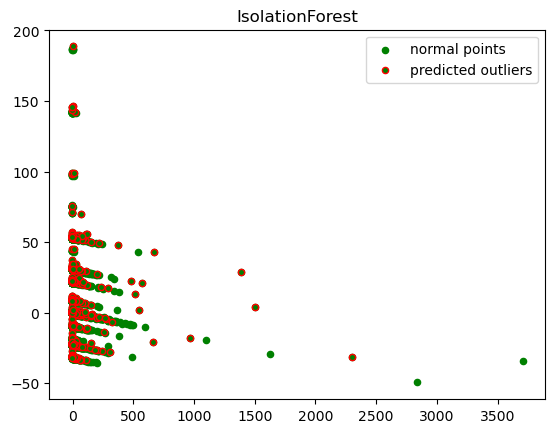

이상치 개수: Counter({1: 49278, -1: 498})
이상치 인덱스: [11, 15, 41, 50, 71, 73, 76, 82, 104, 108, 114, 128, 137, 139, 155, 204, 230, 235, 239, 241, 257, 269, 286, 291, 293, 321, 328, 344, 367, 369, 463, 464, 476, 483, 494, 498, 504, 530, 532, 580, 600, 635, 696, 775, 865, 887, 939, 959, 979, 1004, 1065, 1098, 1129, 1132, 1165, 1206, 1210, 1221, 1267, 1270, 1286, 1428, 1486, 1812, 1846, 1860, 1897, 1958, 2069, 2109, 2222, 2247, 2250, 2271, 2272, 2337, 2470, 2506, 2585, 2632, 2705, 2718, 2799, 3084, 3131, 3189, 3288, 3318, 3330, 3434, 3453, 3510, 3609, 3708, 3785, 4010, 4049, 4105, 4128, 4207, 4221, 4231, 4459, 4662, 4684, 4690, 4701, 4815, 4893, 4935, 4963, 5002, 5031, 5106, 5148, 5157, 5253, 5267, 5359, 5394, 5442, 5832, 5925, 5931, 5933, 6365, 6407, 6565, 6658, 6700, 6724, 6875, 6920, 6933, 7060, 7075, 7137, 7180, 7293, 7398, 7417, 7455, 7478, 7564, 7571, 7630, 7665, 7704, 7792, 7892, 7900, 8056, 8872, 9050, 9090, 9107, 9135, 9201, 9338, 9350, 9405, 9609, 9639, 9861, 10276, 10282, 10398, 10442

In [64]:
outlier_index, outlier_count = detect_outliers_and_plot_pca(trian_with_null_rs, n_estimators=100, contamination=0.01)
print("이상치 개수:", outlier_count)
print("이상치 인덱스:", outlier_index)


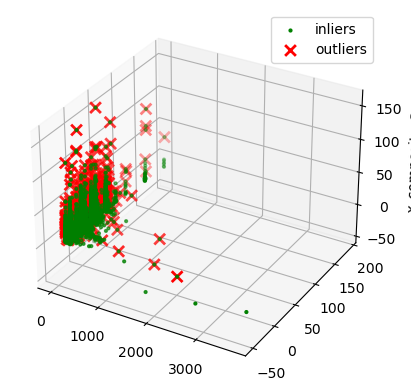

In [65]:
plot_outliers_pca_3d(trian_with_null_rs, outlier_index)


In [66]:
trian_with_null_rs = trian_with_null_rs[trian_with_null_rs['out'] != -1]

## train_not_null

In [67]:
train_not_null_ss = scale_data_with_standard_scaler(train_not_null)

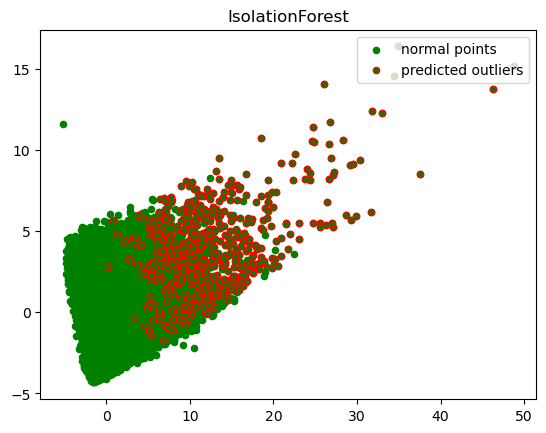

이상치 개수: Counter({1: 49278, -1: 498})
이상치 인덱스: [11, 15, 50, 73, 76, 82, 85, 98, 104, 108, 114, 128, 137, 139, 153, 155, 204, 208, 230, 235, 241, 257, 269, 286, 291, 293, 294, 321, 324, 328, 344, 348, 359, 367, 369, 372, 397, 463, 464, 476, 483, 494, 498, 504, 532, 580, 635, 696, 783, 794, 865, 887, 901, 939, 953, 959, 979, 1065, 1129, 1132, 1165, 1206, 1210, 1221, 1260, 1267, 1270, 1286, 1428, 1473, 1486, 1516, 1803, 1812, 1827, 1846, 1860, 2011, 2069, 2109, 2250, 2271, 2272, 2337, 2411, 2470, 2472, 2506, 2511, 2585, 2632, 2718, 2875, 3084, 3113, 3131, 3318, 3330, 3391, 3434, 3609, 3708, 3885, 3954, 4010, 4105, 4128, 4197, 4207, 4221, 4231, 4287, 4376, 4388, 4459, 4684, 4690, 4701, 4815, 4935, 4963, 5002, 5106, 5148, 5157, 5267, 5342, 5359, 5394, 5442, 5517, 5832, 5925, 5931, 6407, 6565, 6567, 6619, 6658, 6700, 6724, 6860, 6875, 6920, 6933, 7075, 7293, 7398, 7418, 7455, 7478, 7564, 7571, 7630, 7665, 7704, 7792, 7892, 7966, 7983, 8055, 8056, 8736, 9090, 9107, 9135, 9201, 9350, 9405, 9609

In [68]:
outlier_index, outlier_count = detect_outliers_and_plot_pca(train_not_null_ss, n_estimators=100, contamination=0.01)
print("이상치 개수:", outlier_count)
print("이상치 인덱스:", outlier_index)


In [69]:
train_not_null_ss['Churn'] = train1["Churn"]
train_not_null_ss = train_not_null_ss[train_not_null_ss['out'] != -1]

### Robust Scaler

In [70]:
train_not_null_rs = scale_data_with_robust_scaler(train_not_null)

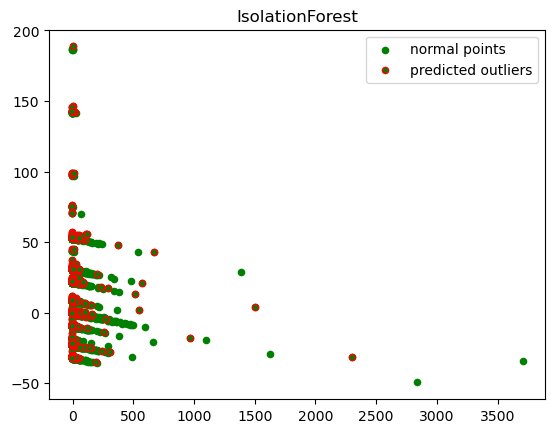

이상치 개수: Counter({1: 49278, -1: 498})
이상치 인덱스: [11, 41, 45, 76, 82, 98, 101, 108, 128, 139, 155, 208, 230, 235, 239, 241, 257, 269, 286, 291, 292, 293, 321, 328, 344, 348, 367, 369, 464, 476, 494, 504, 530, 532, 580, 600, 635, 659, 696, 794, 831, 833, 865, 887, 939, 959, 979, 1004, 1065, 1129, 1206, 1210, 1270, 1286, 1312, 1428, 1486, 1570, 1572, 1846, 2011, 2069, 2104, 2109, 2222, 2250, 2272, 2302, 2337, 2470, 2472, 2506, 2585, 2632, 2705, 2875, 3084, 3131, 3318, 3434, 3609, 3708, 3755, 3785, 4007, 4010, 4041, 4105, 4128, 4207, 4221, 4231, 4287, 4603, 4684, 4690, 4701, 4815, 4891, 4918, 4935, 5002, 5148, 5157, 5178, 5342, 5359, 5394, 5419, 5438, 5442, 5832, 5902, 5925, 5931, 5933, 5952, 6228, 6407, 6565, 6658, 6700, 6724, 6844, 6860, 6875, 6898, 6920, 6933, 6984, 7075, 7270, 7455, 7478, 7564, 7571, 7630, 7665, 7704, 7792, 7892, 7900, 7983, 8054, 8056, 8576, 8872, 9050, 9201, 9259, 9338, 9350, 9405, 9496, 9609, 9864, 9972, 10296, 10503, 10564, 10567, 10578, 10726, 10728, 10830, 11026, 1

In [71]:
outlier_index, outlier_count = detect_outliers_and_plot_pca(train_not_null_rs, n_estimators=100, contamination=0.01)
print("이상치 개수:", outlier_count)
print("이상치 인덱스:", outlier_index)

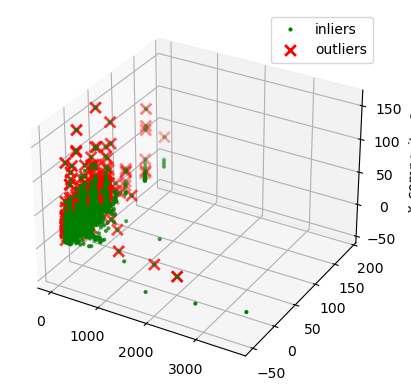

In [72]:
plot_outliers_pca_3d(train_not_null_rs, outlier_index)

In [73]:
train_not_null_rs = train_not_null_rs[train_not_null_rs['out'] != -1]

## OverSampling

~~~
6가지 데이터셋
1. 카이제곱 및 t-test를 통해 컬럼 선정 결측치는 모두 drop - train_null_1
    1) Standard - train_null_1_ss
    2) Robust - train_null_1_rs
2. 결측지 모두 제거 - trian_with_null
    1) Standard - trian_with_null_ss
    2) Robust - trian_with_null_rs
3. 결측치 최빈값 및 평균으로 변경 - train_not_null
    1) Standard - train_not_null_ss
    2) Robust - train_not_null_rs

#### SMOTE 적용 함수

In [74]:
from imblearn.over_sampling import SMOTE
import pandas as pd

def apply_smote(data, target_variable, random_state=70):
    X = data.drop(target_variable, axis=1)
    y = data[target_variable]

    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    data_resampled = pd.concat([X_resampled, y_resampled], axis=1)
    
    return data_resampled

#### SMOTE 시각화 함수

In [75]:
import matplotlib.pyplot as plt

def plot_bar_chart_with_percent(data, column):
    value_counts = data[column].value_counts()

    ax = value_counts.plot(kind='bar', color=['blue', 'orange'])

    def autolabel_percent(rects):
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2, height,
                    f'{height} ({height / value_counts.sum() * 100:.1f}%)',
                    ha='center', va='bottom')

    autolabel_percent(ax.patches)

    plt.xticks(rotation=360)
    plt.show()

#### 1-1. train_null_1_ss

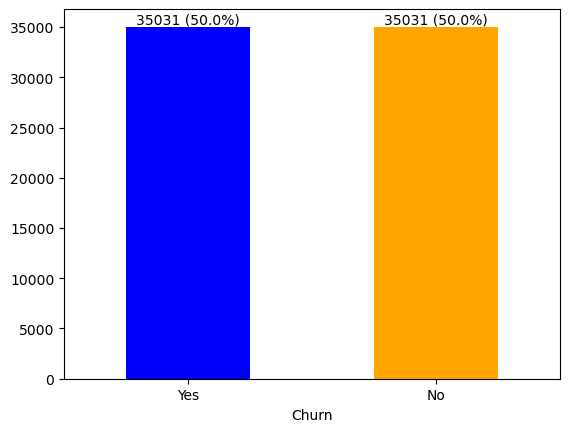

In [76]:
train_null_1_ss = apply_smote(train_null_1_ss, 'Churn')
plot_bar_chart_with_percent(train_null_1_ss, 'Churn')

#### 1-2. train_null_1_rs

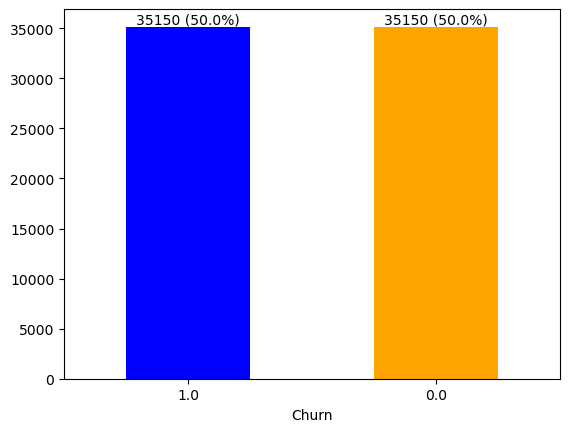

In [77]:
train_null_1_rs = apply_smote(train_null_1_rs, 'Churn')
plot_bar_chart_with_percent(train_null_1_rs, 'Churn')

#### 2-1. trian_with_null_ss

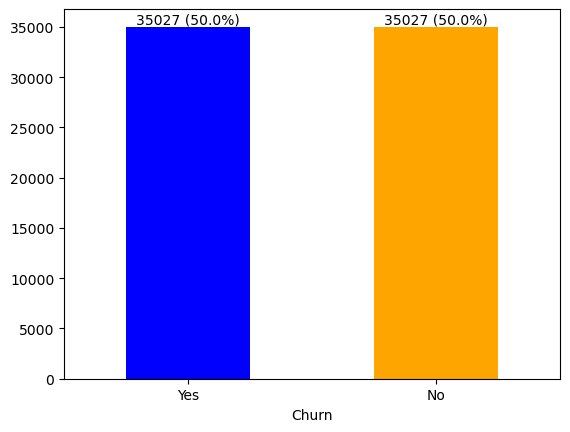

In [78]:
trian_with_null_ss = apply_smote(trian_with_null_ss, 'Churn')
plot_bar_chart_with_percent(trian_with_null_ss, 'Churn')

#### 2-2. trian_with_null_rs

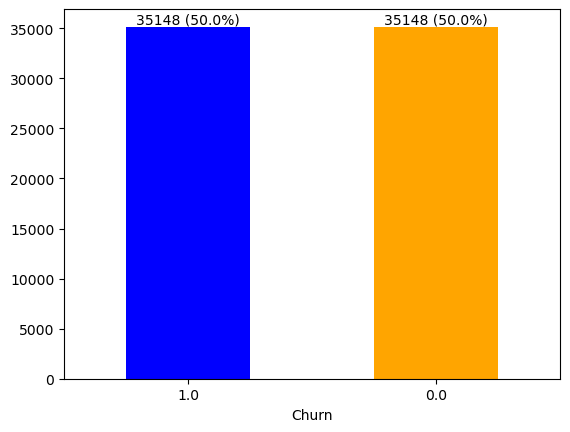

In [79]:
trian_with_null_rs = apply_smote(trian_with_null_rs, 'Churn')
plot_bar_chart_with_percent(trian_with_null_rs, 'Churn')

#### 3-1. train_not_null_ss

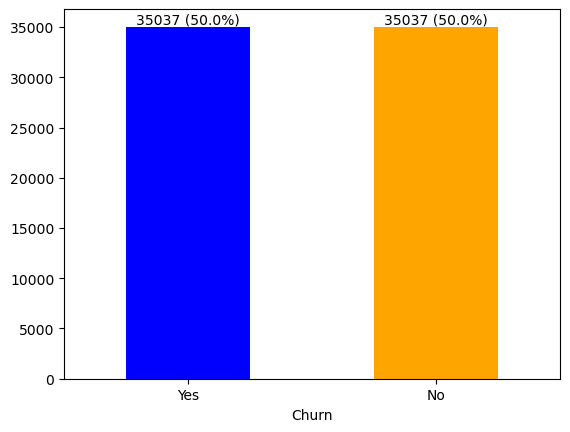

In [80]:
train_not_null_ss = apply_smote(train_not_null_ss, 'Churn')
plot_bar_chart_with_percent(train_not_null_ss, 'Churn')

#### 3-2. train_not_null_rs

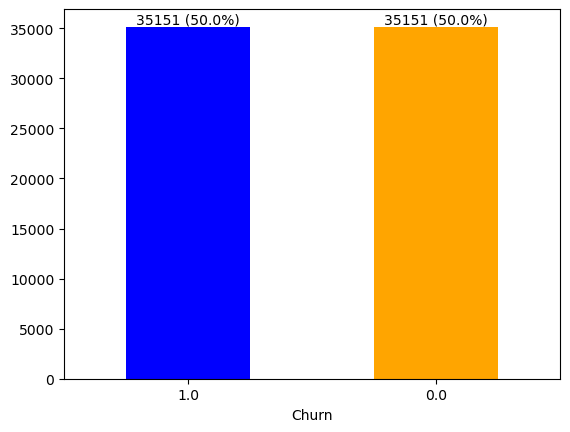

In [81]:
train_not_null_rs = apply_smote(train_not_null_rs, 'Churn')
plot_bar_chart_with_percent(train_not_null_rs, 'Churn')

## 모델 학습

#### 데이터 나누고 확인하는 함수

In [82]:
from sklearn.model_selection import train_test_split

def split_train_test_data(data, target_variable, test_size=0.3, random_state=70):
    
    y = data[target_variable]
    X = data.drop(columns=[target_variable])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print('X train shape: ', X_train.shape)
    print('Y train shape: ', y_train.shape)
    print('X test shape: ', X_test.shape)
    print('Y test shape: ', y_test.shape)

    return X_train, X_test, y_train, y_test


#### 모델 학습 후 5가지 정보 확인하는 코드

In [83]:
def report(y_test, pred):

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    accuracy = accuracy_score(y_test, pred)
    print("Accuracy:", accuracy)

    precision = precision_score(y_test, pred)
    print("Precision:", precision)

    recall = recall_score(y_test, pred)
    print("Recall:", recall)

    f1 = f1_score(y_test, pred)
    print("F1 Score:", f1)

    tn = ((y_test == 0) & (pred == 0)).sum()
    fp = ((y_test == 0) & (pred == 1)).sum()
    specificity = tn / (tn + fp)
    print("Specificity:", specificity)


#### validation 함수

In [85]:
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

def perform_cross_validation(X, y, models):
    results = []
    names = []

    for name, model in models:
        kfold = KFold(n_splits=5, random_state=70, shuffle=True)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)

        print(name, cv_results.mean(), cv_results.std())

models = [
    ('RandomForestClassifier', RandomForestClassifier()),
    ('DecisionTreeClassifier', DecisionTreeClassifier()),
    ('AdaBoostClassifier', AdaBoostClassifier()),
    ('GradientBoostingClassifier', GradientBoostingClassifier()),
    ('LogisticRegression', LogisticRegression())
]


#### 모델별 정보 데이터프레임에 담는 함수 SS용

In [86]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report

def evaluate_models(models, X_train, y_train, X_test, y_test, df):

    for name, model in models:
        kfold = KFold(n_splits=5, random_state=70, shuffle=True)

        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        print(name)
        print(classification_report(y_test, pred, target_names=['No', 'Yes']))

        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred, pos_label='Yes')
        recall = recall_score(y_test, pred, pos_label='Yes')
        f1 = f1_score(y_test, pred, pos_label='Yes')

        model_results = pd.DataFrame({'Model': [name],
                                      'Accuracy': [accuracy],
                                      'Precision': [precision],
                                      'Recall': [recall],
                                      'F1-Score': [f1]})

        df = pd.concat([df, model_results], ignore_index=True)

    return df

models = [
    ('RandomForestClassifier', RandomForestClassifier()),
    ('DecisionTreeClassifier', DecisionTreeClassifier()),
    ('AdaBoostClassifier', AdaBoostClassifier()),
    ('GradientBoostingClassifier', GradientBoostingClassifier()),
    ('LogisticRegression', LogisticRegression())
]



#### 모델별 정보 데이터프레임에 담는 함수 RS용

In [99]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report

def evaluate_models_rs(models, X_train, y_train, X_test, y_test, df):

    for name, model in models:
        kfold = KFold(n_splits=5, random_state=70, shuffle=True)

        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        print(name)
        print(classification_report(y_test, pred, target_names=['No', 'Yes']))

        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred, pos_label=1.0)
        recall = recall_score(y_test, pred, pos_label=1.0)
        f1 = f1_score(y_test, pred, pos_label=1.0)

        model_results = pd.DataFrame({'Model': [name],
                                      'Accuracy': [accuracy],
                                      'Precision': [precision],
                                      'Recall': [recall],
                                      'F1-Score': [f1]})

        df = pd.concat([df, model_results], ignore_index=True)

    return df

models = [
    ('RandomForestClassifier', RandomForestClassifier()),
    ('DecisionTreeClassifier', DecisionTreeClassifier()),
    ('AdaBoostClassifier', AdaBoostClassifier()),
    ('GradientBoostingClassifier', GradientBoostingClassifier()),
    ('LogisticRegression', LogisticRegression())
]

#### train_null_1_ss

In [87]:
X_train, X_test, y_train, y_test = split_train_test_data(train_null_1_ss, 'Churn')

X train shape:  (49043, 43)
Y train shape:  (49043,)
X test shape:  (21019, 43)
Y test shape:  (21019,)


In [88]:
perform_cross_validation(X_train, y_train, models)

RandomForestClassifier 0.7909181454691625 0.0035282654187530783
DecisionTreeClassifier 0.6753666086693031 0.00518552397177697
AdaBoostClassifier 0.7005484442908492 0.004160255003111395
GradientBoostingClassifier 0.7869420615651272 0.0037383690414041757
LogisticRegression 0.5178924617619035 0.002494911351712381


In [89]:
train_null_1_ss_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
train_null_1_ss_df = evaluate_models(models, X_train, y_train, X_test, y_test,train_null_1_ss_df)
train_null_1_ss_df

RandomForestClassifier
              precision    recall  f1-score   support

          No       0.73      0.94      0.82     10470
         Yes       0.92      0.66      0.77     10549

    accuracy                           0.80     21019
   macro avg       0.83      0.80      0.79     21019
weighted avg       0.83      0.80      0.79     21019

DecisionTreeClassifier
              precision    recall  f1-score   support

          No       0.69      0.67      0.68     10470
         Yes       0.68      0.70      0.69     10549

    accuracy                           0.68     21019
   macro avg       0.68      0.68      0.68     21019
weighted avg       0.68      0.68      0.68     21019

AdaBoostClassifier
              precision    recall  f1-score   support

          No       0.67      0.82      0.73     10470
         Yes       0.77      0.59      0.67     10549

    accuracy                           0.70     21019
   macro avg       0.72      0.71      0.70     21019
weighted 

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForestClassifier,0.798373,0.919670,0.655512,0.765442
1,DecisionTreeClassifier,0.683524,0.679337,0.699687,0.689362
2,AdaBoostClassifier,0.704886,0.765129,0.594464,0.669085
3,GradientBoostingClassifier,0.786717,0.992690,0.579297,0.731637
4,LogisticRegression,0.521385,0.520754,0.581572,0.549485


### train_null_1_rs

In [92]:
X_train, X_test, y_train, y_test = split_train_test_data(train_null_1_rs, 'Churn')

X train shape:  (49210, 43)
Y train shape:  (49210,)
X test shape:  (21090, 43)
Y test shape:  (21090,)


In [93]:
perform_cross_validation(X_train, y_train, models)

RandomForestClassifier 0.8077016866490551 0.00143777874019983
DecisionTreeClassifier 0.6994106888843732 0.004001548990903494
AdaBoostClassifier 0.732635643161959 0.0027755937539465474
GradientBoostingClassifier 0.791302580776265 0.0017762059242765556
LogisticRegression 0.5850436903068482 0.0013371821886902508


In [100]:
train_null_1_rs_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
train_null_1_rs_df = evaluate_models_rs(models, X_train, y_train, X_test, y_test,train_null_1_rs_df)
train_null_1_rs_df

RandomForestClassifier
              precision    recall  f1-score   support

          No       0.76      0.92      0.83     10479
         Yes       0.90      0.71      0.79     10611

    accuracy                           0.81     21090
   macro avg       0.83      0.82      0.81     21090
weighted avg       0.83      0.81      0.81     21090

DecisionTreeClassifier
              precision    recall  f1-score   support

          No       0.71      0.70      0.70     10479
         Yes       0.71      0.72      0.71     10611

    accuracy                           0.71     21090
   macro avg       0.71      0.71      0.71     21090
weighted avg       0.71      0.71      0.71     21090

AdaBoostClassifier
              precision    recall  f1-score   support

          No       0.71      0.78      0.75     10479
         Yes       0.76      0.69      0.72     10611

    accuracy                           0.73     21090
   macro avg       0.74      0.73      0.73     21090
weighted 

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForestClassifier,0.814509,0.896625,0.713599,0.794710
1,DecisionTreeClassifier,0.708298,0.707029,0.717557,0.712254
2,AdaBoostClassifier,0.734424,0.762744,0.685327,0.721966
3,GradientBoostingClassifier,0.790849,0.915327,0.643860,0.755961
4,LogisticRegression,0.583404,0.584718,0.593535,0.589094


#### trian_with_null_ss

In [102]:
X_train, X_test, y_train, y_test = split_train_test_data(trian_with_null_ss, 'Churn')

X train shape:  (49037, 55)
Y train shape:  (49037,)
X test shape:  (21017, 55)
Y test shape:  (21017,)


In [104]:
trian_with_null_ss_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
trian_with_null_ss_df = evaluate_models(models, X_train, y_train, X_test, y_test,trian_with_null_ss_df)
trian_with_null_ss_df

RandomForestClassifier
              precision    recall  f1-score   support

          No       0.73      0.95      0.83     10514
         Yes       0.92      0.66      0.77     10503

    accuracy                           0.80     21017
   macro avg       0.83      0.80      0.80     21017
weighted avg       0.83      0.80      0.80     21017

DecisionTreeClassifier
              precision    recall  f1-score   support

          No       0.69      0.67      0.68     10514
         Yes       0.68      0.70      0.69     10503

    accuracy                           0.68     21017
   macro avg       0.68      0.68      0.68     21017
weighted avg       0.68      0.68      0.68     21017

AdaBoostClassifier
              precision    recall  f1-score   support

          No       0.67      0.85      0.75     10514
         Yes       0.79      0.59      0.67     10503

    accuracy                           0.72     21017
   macro avg       0.73      0.72      0.71     21017
weighted 

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForestClassifier,0.801970,0.923920,0.657907,0.768546
1,DecisionTreeClassifier,0.683589,0.678628,0.696849,0.687617
2,AdaBoostClassifier,0.717086,0.794418,0.585357,0.674049
3,GradientBoostingClassifier,0.792739,0.997894,0.586499,0.738786
4,LogisticRegression,0.521673,0.519097,0.582310,0.548889


#### trian_with_null_rs

In [105]:
X_train, X_test, y_train, y_test = split_train_test_data(trian_with_null_rs, 'Churn')

X train shape:  (49207, 55)
Y train shape:  (49207,)
X test shape:  (21089, 55)
Y test shape:  (21089,)


In [106]:
trian_with_null_rs_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
trian_with_null_rs_df = evaluate_models_rs(models, X_train, y_train, X_test, y_test,trian_with_null_rs_df)
trian_with_null_rs_df

RandomForestClassifier
              precision    recall  f1-score   support

          No       0.75      0.93      0.83     10545
         Yes       0.91      0.70      0.79     10544

    accuracy                           0.81     21089
   macro avg       0.83      0.81      0.81     21089
weighted avg       0.83      0.81      0.81     21089

DecisionTreeClassifier
              precision    recall  f1-score   support

          No       0.72      0.70      0.71     10545
         Yes       0.71      0.72      0.72     10544

    accuracy                           0.71     21089
   macro avg       0.71      0.71      0.71     21089
weighted avg       0.71      0.71      0.71     21089

AdaBoostClassifier
              precision    recall  f1-score   support

          No       0.71      0.79      0.75     10545
         Yes       0.76      0.68      0.72     10544

    accuracy                           0.74     21089
   macro avg       0.74      0.74      0.73     21089
weighted 

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForestClassifier,0.812841,0.906670,0.697458,0.788421
1,DecisionTreeClassifier,0.712172,0.707861,0.722496,0.715104
2,AdaBoostClassifier,0.735170,0.764762,0.679249,0.719474
3,GradientBoostingClassifier,0.792925,0.908370,0.651555,0.758823
4,LogisticRegression,0.586135,0.582366,0.608877,0.595326


#### train_not_null_ss

In [107]:
X_train, X_test, y_train, y_test = split_train_test_data(train_not_null_ss, 'Churn')

X train shape:  (49051, 55)
Y train shape:  (49051,)
X test shape:  (21023, 55)
Y test shape:  (21023,)


In [108]:
train_not_null_ss_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
train_not_null_ss_df = evaluate_models(models, X_train, y_train, X_test, y_test,train_not_null_ss_df)
train_not_null_ss_df

RandomForestClassifier
              precision    recall  f1-score   support

          No       0.73      0.95      0.82     10490
         Yes       0.93      0.65      0.76     10533

    accuracy                           0.80     21023
   macro avg       0.83      0.80      0.79     21023
weighted avg       0.83      0.80      0.79     21023

DecisionTreeClassifier
              precision    recall  f1-score   support

          No       0.68      0.67      0.67     10490
         Yes       0.68      0.69      0.68     10533

    accuracy                           0.68     21023
   macro avg       0.68      0.68      0.68     21023
weighted avg       0.68      0.68      0.68     21023

AdaBoostClassifier
              precision    recall  f1-score   support

          No       0.68      0.85      0.75     10490
         Yes       0.80      0.59      0.68     10533

    accuracy                           0.72     21023
   macro avg       0.74      0.72      0.72     21023
weighted 

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForestClassifier,0.797745,0.926409,0.647774,0.762432
1,DecisionTreeClassifier,0.678638,0.675104,0.691256,0.683085
2,AdaBoostClassifier,0.721591,0.800926,0.591285,0.680321
3,GradientBoostingClassifier,0.791181,0.995963,0.585588,0.737534
4,LogisticRegression,0.527089,0.525293,0.582645,0.552485


#### train_not_null_rs

In [109]:
X_train, X_test, y_train, y_test = split_train_test_data(train_not_null_rs, 'Churn')

X train shape:  (49211, 55)
Y train shape:  (49211,)
X test shape:  (21091, 55)
Y test shape:  (21091,)


In [110]:
train_not_null_rs_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
train_not_null_rs_df = evaluate_models_rs(models, X_train, y_train, X_test, y_test,train_not_null_rs_df)
train_not_null_rs_df

RandomForestClassifier
              precision    recall  f1-score   support

          No       0.75      0.93      0.83     10457
         Yes       0.91      0.69      0.78     10634

    accuracy                           0.81     21091
   macro avg       0.83      0.81      0.81     21091
weighted avg       0.83      0.81      0.81     21091

DecisionTreeClassifier
              precision    recall  f1-score   support

          No       0.72      0.70      0.71     10457
         Yes       0.71      0.73      0.72     10634

    accuracy                           0.71     21091
   macro avg       0.71      0.71      0.71     21091
weighted avg       0.71      0.71      0.71     21091

AdaBoostClassifier
              precision    recall  f1-score   support

          No       0.72      0.79      0.75     10457
         Yes       0.77      0.69      0.73     10634

    accuracy                           0.74     21091
   macro avg       0.74      0.74      0.74     21091
weighted 

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForestClassifier,0.808544,0.910710,0.687700,0.783648
1,DecisionTreeClassifier,0.714238,0.713031,0.725033,0.718982
2,AdaBoostClassifier,0.742260,0.772718,0.692496,0.730411
3,GradientBoostingClassifier,0.791665,0.914783,0.647075,0.757986
4,LogisticRegression,0.585937,0.587676,0.599116,0.593341


## 컬럼 및 모델 선정
~~~
데이터셋 : train_null_1_rs
    - 카이제곱 및 t-tesst를 통해 컬럼 선정
    - 총 43개의 컬럼
    - 결측치는 모두 drop
    - Robust Scaler를 적용
    - oversampling은 50:50으로 적용

모델 : RandomForestClassifier
    - 6개의 데이터셋 중 가장 높은 F1-Score, Recall 값을 보임
    - 또한 비교적 다른 모덻보다 차이가 크지 않다.

In [112]:
def find_best_features(dataset, classifier):
    X = dataset.drop('Churn', axis=1)
    y = dataset['Churn']

    best_score = 0.0
    best_features = {}
    
    clf = classifier()
    
    scores = []
    features_list = []
    for i in range(1, len(X.columns) + 1):
        features = X.columns[:i]
        X_subset = X[features]
        score = cross_val_score(clf, X_subset, y, cv=5).mean()
        scores.append(score)
        features_list.append(features)

    max_score = max(scores)
    best_score = max_score
    best_features = {classifier.__name__: features_list[scores.index(max_score)]}

    return best_features, best_score


### 랜덤포레스트

In [111]:
classifier = RandomForestClassifier
best_features, best_score = find_best_features(train_null_1_rs, classifier)
print("Best Features and Score:")
print(f"{classifier.__name__}: {best_features[classifier.__name__]} (Score: {best_score})")


Best Features and Score:
RandomForestClassifier: Index(['ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable',
       'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers',
       'HandsetPrice', 'MadeCallToRetentionTeam', 'CreditRating', 'PrizmCode',
       'MaritalStatus', 'MonthlyRevenue', 'MonthlyMinutes',
       'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes',
       'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues',
       'DroppedCalls', 'UnansweredCalls', 'CustomerCareCalls', 'ThreewayCalls',
       'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut',
       'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallWaitingCalls'],
      dtype='object') (Score: 0.7447368421052631)


In [137]:
train_final = train1[['ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable',
       'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers',
       'HandsetPrice', 'MadeCallToRetentionTeam', 'CreditRating', 'PrizmCode',
       'MaritalStatus', 'MonthlyRevenue', 'MonthlyMinutes',
       'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes',
       'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues',
       'DroppedCalls', 'UnansweredCalls', 'CustomerCareCalls', 'ThreewayCalls',
       'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut',
       'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallWaitingCalls','Churn']]

In [115]:
X_train, X_test, y_train, y_test = split_train_test_data(train_final, 'Churn')

X train shape:  (49210, 30)
Y train shape:  (49210,)
X test shape:  (21090, 30)
Y test shape:  (21090,)


In [116]:
train_final_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
train_final_df = evaluate_models_rs(models, X_train, y_train, X_test, y_test,train_final_df)
train_final_df

RandomForestClassifier
              precision    recall  f1-score   support

          No       0.74      0.94      0.83     10479
         Yes       0.92      0.68      0.78     10611

    accuracy                           0.81     21090
   macro avg       0.83      0.81      0.80     21090
weighted avg       0.83      0.81      0.80     21090

DecisionTreeClassifier
              precision    recall  f1-score   support

          No       0.70      0.68      0.69     10479
         Yes       0.69      0.71      0.70     10611

    accuracy                           0.70     21090
   macro avg       0.70      0.70      0.70     21090
weighted avg       0.70      0.70      0.70     21090

AdaBoostClassifier
              precision    recall  f1-score   support

          No       0.69      0.81      0.75     10479
         Yes       0.78      0.64      0.70     10611

    accuracy                           0.72     21090
   macro avg       0.73      0.72      0.72     21090
weighted 

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForestClassifier,0.807018,0.919995,0.675148,0.778780
1,DecisionTreeClassifier,0.695638,0.691626,0.712939,0.702121
2,AdaBoostClassifier,0.724277,0.775569,0.636038,0.698907
3,GradientBoostingClassifier,0.786818,0.956957,0.603430,0.740146
4,LogisticRegression,0.564533,0.565011,0.584394,0.574539


In [138]:
final_numeric_columns = train_final.select_dtypes(include="number").columns
print(final_numeric_columns)

Index(['MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge',
       'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls',
       'PercChangeMinutes', 'PercChangeRevenues', 'DroppedCalls',
       'UnansweredCalls', 'CustomerCareCalls', 'ThreewayCalls',
       'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut',
       'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallWaitingCalls'],
      dtype='object')


In [139]:
final_binary_columns = train_final.columns[(train_final.nunique() == 2) & (train_final.dtypes == "object")]
for i in binary_cols :
    train_final[i] = train_final[i].replace({'Yes' : 1, 'No' : 0})

train_final['Homeownership'] = train_final['Homeownership'].replace({"Known" : 1, "Unknown" : 0})
train_final

,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,Homeownership,BuysViaMailOrder,RespondsToMailOffers,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,...,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallWaitingCalls,Churn
0,0,0,1,1,1,1,30,1,1-Highest,Suburban,...,0.0,0.0,97.2,0.0,0.0,58.0,24.0,1.3,0.3,1
1,1,0,0,1,1,1,30,0,4-Medium,Suburban,...,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.3,0.0,1
2,1,0,0,0,0,0,Unknown,0,3-Good,Town,...,0.0,0.0,0.4,0.3,0.0,1.3,3.7,0.0,0.0,0
3,0,0,1,1,1,1,10,0,4-Medium,Other,...,4.3,1.3,200.3,370.3,147.0,555.7,303.7,59.7,22.7,0
4,0,0,0,1,1,1,10,0,1-Highest,Other,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,0,1,1,1,1,1,60,0,1-Highest,Suburban,...,0.0,0.0,58.9,17.0,1.3,160.3,33.3,12.0,0.3,1
51043,1,0,1,1,1,1,60,0,3-Good,Other,...,0.0,0.0,681.5,89.7,33.3,318.7,248.3,17.3,14.3,0
51044,0,0,1,1,0,0,80,0,5-Low,Other,...,1.3,13.7,1225.3,430.3,87.7,1359.0,910.3,76.0,6.7,1
51045,1,0,1,0,0,0,30,0,5-Low,Other,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [140]:
final_categorical_columns = train_final[['CreditRating', 'PrizmCode', 'MaritalStatus']]
final_train_with_cat = final_categorical_columns.apply(le.fit_transform)
train_final[['CreditRating', 'PrizmCode', 'MaritalStatus']] = final_train_with_cat[['CreditRating', 'PrizmCode', 'MaritalStatus']]
train_final

,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,Homeownership,BuysViaMailOrder,RespondsToMailOffers,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,...,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallWaitingCalls,Churn
0,0,0,1,1,1,1,30,1,0,2,...,0.0,0.0,97.2,0.0,0.0,58.0,24.0,1.3,0.3,1
1,1,0,0,1,1,1,30,0,3,2,...,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.3,0.0,1
2,1,0,0,0,0,0,Unknown,0,2,3,...,0.0,0.0,0.4,0.3,0.0,1.3,3.7,0.0,0.0,0
3,0,0,1,1,1,1,10,0,3,0,...,4.3,1.3,200.3,370.3,147.0,555.7,303.7,59.7,22.7,0
4,0,0,0,1,1,1,10,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,0,1,1,1,1,1,60,0,0,2,...,0.0,0.0,58.9,17.0,1.3,160.3,33.3,12.0,0.3,1
51043,1,0,1,1,1,1,60,0,2,0,...,0.0,0.0,681.5,89.7,33.3,318.7,248.3,17.3,14.3,0
51044,0,0,1,1,0,0,80,0,4,0,...,1.3,13.7,1225.3,430.3,87.7,1359.0,910.3,76.0,6.7,1
51045,1,0,1,0,0,0,30,0,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [141]:
final_mean_price = train_final.loc[train_final['HandsetPrice'] != 'Unknown', 'HandsetPrice'].astype(float).mean()
train_final.loc[train_final['HandsetPrice'] == 'Unknown', 'HandsetPrice'] = final_mean_price

In [142]:
train_final

,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,Homeownership,BuysViaMailOrder,RespondsToMailOffers,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,...,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallWaitingCalls,Churn
0,0,0,1,1,1,1,30,1,0,2,...,0.0,0.0,97.2,0.0,0.0,58.0,24.0,1.3,0.3,1
1,1,0,0,1,1,1,30,0,3,2,...,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.3,0.0,1
2,1,0,0,0,0,0,82.237933,0,2,3,...,0.0,0.0,0.4,0.3,0.0,1.3,3.7,0.0,0.0,0
3,0,0,1,1,1,1,10,0,3,0,...,4.3,1.3,200.3,370.3,147.0,555.7,303.7,59.7,22.7,0
4,0,0,0,1,1,1,10,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,0,1,1,1,1,1,60,0,0,2,...,0.0,0.0,58.9,17.0,1.3,160.3,33.3,12.0,0.3,1
51043,1,0,1,1,1,1,60,0,2,0,...,0.0,0.0,681.5,89.7,33.3,318.7,248.3,17.3,14.3,0
51044,0,0,1,1,0,0,80,0,4,0,...,1.3,13.7,1225.3,430.3,87.7,1359.0,910.3,76.0,6.7,1
51045,1,0,1,0,0,0,30,0,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [143]:
train_final.isnull().sum().sort_values(ascending=False)

PercChangeRevenues         367
PercChangeMinutes          367
MonthlyRevenue             156
RoamingCalls               156
DirectorAssistedCalls      156
TotalRecurringCharge       156
MonthlyMinutes             156
OverageMinutes             156
ReceivedCalls                0
DroppedCalls                 0
CustomerCareCalls            0
OutboundCalls                0
InboundCalls                 0
PeakCallsInOut               0
OffPeakCallsInOut            0
UnansweredCalls              0
DroppedBlockedCalls          0
CallWaitingCalls             0
ThreewayCalls                0
ChildrenInHH                 0
HandsetRefurbished           0
MaritalStatus                0
PrizmCode                    0
CreditRating                 0
MadeCallToRetentionTeam      0
HandsetPrice                 0
RespondsToMailOffers         0
BuysViaMailOrder             0
Homeownership                0
HandsetWebCapable            0
Churn                        0
dtype: int64

In [147]:
train_final = train_final.dropna()

In [148]:
train_final_rs = scale_data_with_robust_scaler(train_final)
train_final_rs.head(1)

,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,Homeownership,BuysViaMailOrder,RespondsToMailOffers,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,...,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallWaitingCalls,Churn,out
0,0.0,0.0,0.0,0.0,1.0,1.0,-23.342041,1.0,-0.5,0.5,...,0.0,0.302198,-0.446254,-0.215054,-0.043699,-0.15,-0.373832,0.0,1.0,0.0


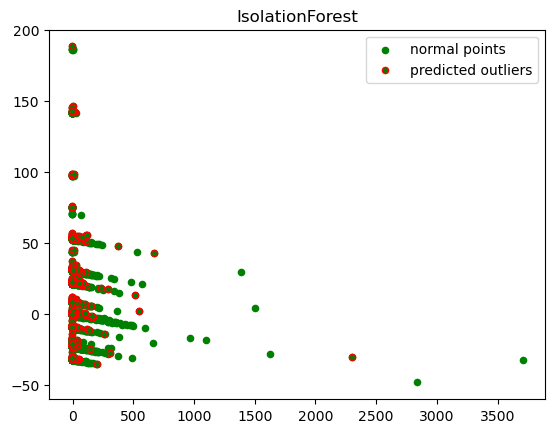

이상치 개수: Counter({1: 50173, -1: 507})
이상치 인덱스: [41, 77, 110, 130, 158, 262, 274, 297, 299, 335, 353, 379, 382, 474, 487, 515, 541, 543, 649, 713, 906, 959, 999, 1086, 1152, 1226, 1296, 1313, 1339, 1515, 1601, 1982, 1991, 2144, 2182, 2310, 2381, 2519, 2632, 2679, 2930, 3143, 3224, 3497, 3675, 3776, 3792, 3854, 4120, 4177, 4200, 4284, 4299, 4309, 4366, 4541, 4769, 4775, 4978, 5051, 5194, 5237, 5420, 5436, 5513, 5533, 5537, 5934, 6037, 6039, 6335, 6516, 6761, 6770, 6813, 6838, 6906, 6960, 6991, 7033, 7037, 7050, 7194, 7320, 7390, 7538, 7575, 7598, 7686, 7693, 7752, 7787, 7919, 8095, 8185, 8294, 8873, 9235, 9252, 9346, 9484, 9496, 10014, 10723, 10726, 10888, 11193, 11216, 11426, 11437, 11473, 11501, 11576, 11773, 11799, 12016, 12129, 12175, 12190, 12280, 12307, 12367, 12393, 12543, 12593, 12709, 12738, 12938, 13151, 13261, 13271, 13399, 13510, 13518, 13706, 13730, 13875, 14304, 14319, 14343, 14414, 14426, 14428, 14639, 14667, 14920, 14936, 14964, 15081, 15493, 15693, 16172, 16917, 17156, 17

In [149]:
outlier_index, outlier_count = detect_outliers_and_plot_pca(train_final_rs, n_estimators=100, contamination=0.01)
print("이상치 개수:", outlier_count)
print("이상치 인덱스:", outlier_index)

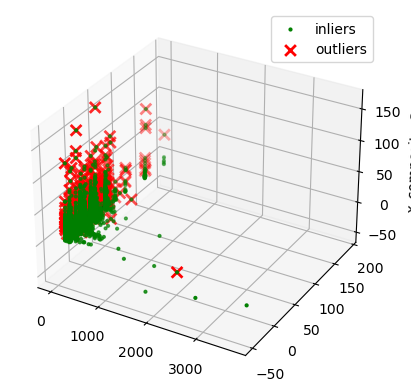

In [150]:
plot_outliers_pca_3d(train_final_rs, outlier_index)

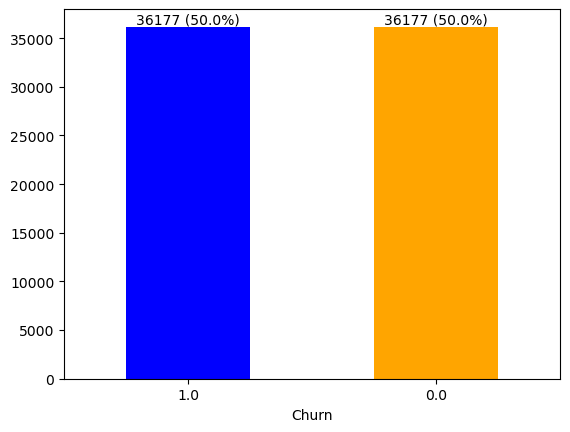

In [151]:
train_final_rs_rs = apply_smote(train_final_rs, 'Churn')
plot_bar_chart_with_percent(train_final_rs_rs, 'Churn')

In [155]:
X_train, X_test, y_train, y_test = split_train_test_data(train_final_rs_rs, 'Churn')

X train shape:  (50647, 31)
Y train shape:  (50647,)
X test shape:  (21707, 31)
Y test shape:  (21707,)


In [156]:
train_final_rs_rs_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
train_final_rs_rs_df = evaluate_models_rs(models, X_train, y_train, X_test, y_test,train_final_rs_rs_df)
train_final_rs_rs_df

RandomForestClassifier
              precision    recall  f1-score   support

          No       0.75      0.93      0.83     10797
         Yes       0.91      0.69      0.79     10910

    accuracy                           0.81     21707
   macro avg       0.83      0.81      0.81     21707
weighted avg       0.83      0.81      0.81     21707

DecisionTreeClassifier
              precision    recall  f1-score   support

          No       0.71      0.69      0.70     10797
         Yes       0.70      0.71      0.71     10910

    accuracy                           0.70     21707
   macro avg       0.70      0.70      0.70     21707
weighted avg       0.70      0.70      0.70     21707

AdaBoostClassifier
              precision    recall  f1-score   support

          No       0.69      0.80      0.74     10797
         Yes       0.77      0.64      0.70     10910

    accuracy                           0.72     21707
   macro avg       0.73      0.72      0.72     21707
weighted 

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForestClassifier,0.809785,0.908740,0.690926,0.785004
1,DecisionTreeClassifier,0.704704,0.702812,0.714665,0.708689
2,AdaBoostClassifier,0.721334,0.766356,0.640972,0.698078
3,GradientBoostingClassifier,0.786659,0.938784,0.615674,0.743648
4,LogisticRegression,0.571659,0.570344,0.598992,0.584317


#### GBC

In [157]:
classifier = GradientBoostingClassifier
best_features, best_score = find_best_features(train_final, classifier)
print("Best Features and Score:")
print(f"{classifier.__name__}: {best_features[classifier.__name__]} (Score: {best_score})")

Best Features and Score:
GradientBoostingClassifier: Index(['ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable',
       'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers',
       'HandsetPrice', 'MadeCallToRetentionTeam', 'CreditRating', 'PrizmCode',
       'MaritalStatus', 'MonthlyRevenue', 'MonthlyMinutes',
       'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes',
       'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues',
       'DroppedCalls', 'UnansweredCalls'],
      dtype='object') (Score: 0.7181728492501974)


In [158]:
train_final_gb = train1[['ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable',
       'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers',
       'HandsetPrice', 'MadeCallToRetentionTeam', 'CreditRating', 'PrizmCode',
       'MaritalStatus', 'MonthlyRevenue', 'MonthlyMinutes',
       'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes',
       'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues',
       'DroppedCalls', 'UnansweredCalls','Churn']]

In [159]:
X_train, X_test, y_train, y_test = split_train_test_data(train_final_gb, 'Churn')

X train shape:  (35732, 21)
Y train shape:  (35732,)
X test shape:  (15315, 21)
Y test shape:  (15315,)
